# Anthropogenic heat from buildings

This notebook is used to process building energy use, analyze data, and ultimately produce the anthropogenic heat flux (AHF) from buildings for the Greater Los Angeles (LA) region.

In [1]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
#import requests
import geopandas as gpd
import pyproj
import shapely.geometry
import contextily as ctx
from matplotlib.ticker import FormatStrFormatter
import geofeather
import dask_geopandas as dgpd
import pyogrio
import folium
import numpy as np

## TESTING: run university park example with dask dataframes

In [ ]:
# Import Energy Atlas data
energy_atlas_data_path = Path('data/energy_atlas')
usage_file = energy_atlas_data_path / 'usage_bld_btu.csv'
usage_bld_btu = pd.read_csv(usage_file, na_values = ['masked'])

In [ ]:
# Import LARIAC and parcel data
lariac_usc_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017_usc.geojson'
lariac_usc_df = dgpd.read_file(lariac_usc_dir, npartitions=10)
parcels_usc_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/LA_County_Parcels_usc.geojson'
parcels_usc_df = dgpd.read_file(parcels_usc_dir, npartitions=10)

In [ ]:
# rename OBJECTID to avoid duplicate column names
lariac_usc_df = lariac_usc_df.rename(columns={'OBJECTID':'lariac_id'})
parcels_usc_df = parcels_usc_df.rename(columns={'OBJECTID':'parcel_id'})

# choose columns to keep
lariac_columns = ['lariac_id',
 'CODE',
 'BLD_ID',
 'HEIGHT',
 'ELEV',
 'DATE_',
 'STATUS',
 'AREA',
 'geometry']

parcels_columns = ['parcel_id',
 'AIN',
 'APN',
 'UseType',
 'UseDescrip',
 'DesignType',
 'CENTER_LAT',
 'CENTER_LON',
 'CENTER_X',
 'CENTER_Y',
 'LAT_LON',
 'ShapeSTAre',
 'ShapeSTLen',
 'geometry']

# keep only columns listed above
lariac_usc_df = lariac_usc_df[lariac_columns]
parcels_usc_df = parcels_usc_df[parcels_columns]

# calculate shape area from geometry in units of meters squared
lariac_usc_df['shape_area_whole'] = lariac_usc_df.to_crs('epsg:3857').geometry.area

# delete courtyards, keep only buildings
lariac_usc_df = lariac_usc_df[lariac_usc_df['CODE']!='Courtyard']

In [ ]:
# Download Neighborhoods boundaries
# source: https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr
neighborhoods_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/la_bound_nbhd.geojson'
neighborhoods = gpd.read_file(neighborhoods_dir)

# Remove Catalina Island (including Avalon) from dataframe
catalina_index = neighborhoods.query('name.str.contains("Catalina") | name.str.contains("Avalon")').index
neighborhoods.drop(catalina_index, inplace=True)

# Merge neighborhoods w/ Energy Atlas data
neighborhoods_lower = neighborhoods.copy()
neighborhoods_lower['name'] = neighborhoods_lower['name'].str.lower()
usage_bld = neighborhoods_lower.merge(usage_bld_btu, on='name')

# clean up dataframe, drop unnecessary columns
cols_drop = ['external_i','slug_1','display_na', 'set', 'name_1']
usage_bld.drop(cols_drop, axis=1, inplace=True)

# add column for usage in units of Joules (1 btu = 1055.06 joules)
usage_bld['usage_joules'] = usage_bld['usage']*1055.06

In [ ]:
# get usage for university park neighborhood only
usage_usc = usage_bld[(usage_bld['name'] == 'university park') & (usage_bld['usetype'] == 'res_total')]

# create 2d grid
xmin, ymin, xmax, ymax = usage_usc.total_bounds

# create a little buffer for extent
xmin = xmin - 0.005
ymin = ymin - 0.005
xmax = xmax + 0.005
ymax = ymax + 0.005

# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)
to_original_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((xmin, ymin))
ne = shapely.geometry.Point((xmax, ymax))

stepsize = 100 # grid resolution in meters

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE

# Iterate over 2D area
grid_cells = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        x1 = x + stepsize
        y1 = y + stepsize
        cell = shapely.geometry.box(x, y, x1, y1)
        grid_cells.append(cell)
        y += stepsize
    x += stepsize


ah_grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='epsg:3857')
ah_grid = ah_grid.to_crs('epsg:4326')

In [ ]:
# spatial join LARIAC and parcels dataframe
parcels_usc_res_df = parcels_usc_df[parcels_usc_df['UseType'] == 'Residential'] # filter for only residential
parcels_usc_res_df = parcels_usc_res_df.drop_duplicates('geometry') # !!!REMOVE DUPLICATE PARCELS!!!
lariac_usc_merged_inner = dgpd.sjoin(lariac_usc_df, parcels_usc_res_df, how='inner')

In [ ]:
# spatial join the 2d grid and the neighborhood boundary
grid_usc = gpd.sjoin(ah_grid, usage_usc)

In [ ]:
# drop columns with 'index_*'
grid_usc.drop(list(grid_usc.filter(regex = 'index_')), axis=1, inplace=True)
lariac_usc_merged_inner = lariac_usc_merged_inner.loc[:, ~lariac_usc_merged_inner.columns.str.startswith('index_')]

# add extra geometry column to save grid geometry for spatial joins
grid_usc['grid_geometry'] = grid_usc.geometry

# make the index a column
grid_usc.reset_index(inplace=True)

# rename index to grid_cell_index
grid_usc.rename(columns={'index':'grid_cell_index'}, inplace=True)

In [ ]:
# spatial join buildings and grid (intersects)
buildings_usc_intersects = dgpd.sjoin(lariac_usc_merged_inner, grid_usc, predicate='intersects')

In [ ]:
# create overlay (clip buildings with grid)
"""
Summary of error:
- As of 4/9/22 no overlay compatibilit with dask geopandas
- https://github.com/geopandas/dask-geopandas/issues/130
- try: using clip instead of overlay
- clip does not retain the attributes of the grid -> does NOT work
- 4/9/22: try converting to geopandas df first using compute()
"""
buildings_usc_overlay_intersection = lariac_usc_merged_inner.compute().overlay(grid_usc, how='intersection')
#buildings_usc_overlay_intersection = lariac_usc_merged_inner.clip(grid_usc)

In [ ]:
# === Calculations === 
# total building area in this neighborhood?
total_building_area_usc = buildings_usc_overlay_intersection['AREA'].sum()

# calculate building volume and add as a new column
buildings_usc_overlay_intersection['VOLUME'] = buildings_usc_overlay_intersection['AREA']*buildings_usc_overlay_intersection['HEIGHT'] # units: cubic feet

# add column that describes the fraction of the whole building that segment represents
buildings_usc_overlay_intersection['building_fraction'] = buildings_usc_overlay_intersection.to_crs('epsg:3857').geometry.area/buildings_usc_overlay_intersection['shape_area_whole']
buildings_usc_overlay_intersection['VOLUME'] = buildings_usc_overlay_intersection['building_fraction']*buildings_usc_overlay_intersection['VOLUME']

# total building area in this neighborhood?
total_building_vol_usc = buildings_usc_overlay_intersection['VOLUME'].sum()

# df of total building volume in each grid cell
building_volume_df = buildings_usc_overlay_intersection[['grid_cell_index', 'VOLUME']]
volume_by_cell = building_volume_df.groupby('grid_cell_index').sum()

# make the index a column
volume_by_cell.reset_index(inplace=True)

# add cells with no buildings 
volume_by_cell_all = volume_by_cell.merge(grid_usc, how='outer') # outer join
volume_by_cell_all = volume_by_cell_all[['grid_cell_index','VOLUME','pct_elec','usage_joules','grid_geometry']] # only keep these columns

# calculate volume-based weights and finally, the AHF
cell_area = stepsize**2 # area of single cell; stepsize is resolution in meters (defined above)
n_cells = len(grid_usc) # number of total cells in neighborhood
seconds_in_year = 3.154e+7
ahf = gpd.GeoDataFrame(volume_by_cell_all, geometry='grid_geometry')
ahf['VOLUME'] = ahf['VOLUME'].fillna(0)
ahf['vol_frac'] = ahf['VOLUME']/total_building_vol_usc
ahf['electricity_use'] = ahf['pct_elec']*ahf['usage_joules']*ahf['vol_frac']
ahf['ahf'] = ahf['electricity_use']/cell_area/seconds_in_year

In [ ]:
# finally plot the data

# plot to visualize
ax = ahf.plot(figsize=(10,10), column='ahf', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_intersects.compute().plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [ ]:
# convert geopandas dataframe to raster (xarray)
"""
Try using geocube
https://github.com/corteva/geocube
"""


## TESTING: University Park Test Case: Convert building polygons to points and compare to polygon-weighting

In [ ]:
# Create a copy of lariac_usc_df and replace polygon geometry with points
lariac_usc_points_df = lariac_usc_df.copy()
lariac_usc_points_df['geometry'] = lariac_usc_df.geometry.to_crs('epsg:3857').centroid
lariac_usc_points_df['geometry'] = lariac_usc_points_df.geometry.to_crs('epsg:4326')

In [ ]:
#lariac_usc_points_df.compute().plot()

In [ ]:
# spatial join new lariac points df with parcels df 
lariac_points_usc_merged_inner = dgpd.sjoin(lariac_usc_points_df, parcels_usc_res_df, how='inner')

# drop columns with 'index_*'
lariac_points_usc_merged_inner = lariac_points_usc_merged_inner.loc[:, ~lariac_points_usc_merged_inner.columns.str.startswith('index_')]

# spatial join buildings centroids and grid
#buildings_usc_overlay_intersection = lariac_usc_merged_inner.compute().overlay(grid_usc, how='intersection')
buildings_grid_join = dgpd.sjoin(lariac_points_usc_merged_inner, grid_usc)

In [ ]:
# === Calculations === 
# total building area in this neighborhood?
total_building_area_usc = buildings_grid_join['AREA'].sum()

# calculate building volume and add as a new column
buildings_grid_join['VOLUME'] = buildings_grid_join['AREA']*buildings_grid_join['HEIGHT'] # units: cubic feet

# # add column that describes the fraction of the whole building that segment represents
# buildings_grid_join['building_fraction'] = buildings_grid_join.to_crs('epsg:3857').geometry.area/buildings_grid_join['shape_area_whole']
# buildings_grid_join['VOLUME'] = buildings_grid_join['building_fraction']*buildings_grid_join['VOLUME']

# total building area in this neighborhood?
total_building_vol_usc = buildings_grid_join['VOLUME'].sum()

# df of total building volume in each grid cell
building_volume_df = buildings_grid_join[['grid_cell_index', 'VOLUME']]
volume_by_cell = building_volume_df.groupby('grid_cell_index').sum()

# make the index a column
volume_by_cell = volume_by_cell.compute()
volume_by_cell.reset_index(inplace=True)

# add cells with no buildings 
volume_by_cell_all = volume_by_cell.merge(grid_usc, how='outer') # outer join
volume_by_cell_all = volume_by_cell_all[['grid_cell_index','VOLUME','pct_elec','usage_joules','grid_geometry']] # only keep these columns

# calculate volume-based weights and finally, the AHF
cell_area = stepsize**2 # area of single cell; stepsize is resolution in meters (defined above)
n_cells = len(grid_usc) # number of total cells in neighborhood
seconds_in_year = 3.154e+7
ahf = gpd.GeoDataFrame(volume_by_cell_all, geometry='grid_geometry')
ahf['VOLUME'] = ahf['VOLUME'].fillna(0)
ahf['vol_frac'] = ahf['VOLUME']/total_building_vol_usc
ahf['electricity_use'] = ahf['pct_elec']*ahf['usage_joules']*ahf['vol_frac']
ahf['ahf'] = ahf['electricity_use']/cell_area/seconds_in_year

In [ ]:
# plot to visualize
ax = ahf.plot(figsize=(10,10), column='ahf', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_intersects.compute().plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

### scratch

In [ ]:
# lariac = lariac_usc_points_df.compute()
# lariac.head()

In [ ]:
# # convert points to lat/lon
# lariac['geometry'] = lariac['geometry'].to_crs('epsg:4326')

In [ ]:
# # plot centroids and building footprints on map
# # ax = lariac.plot(figsize=(16,10), alpha=0.7, color = 'red', markersize = 5)
# # ax.get_xaxis().get_major_formatter().set_useOffset(False)
# # ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
# # ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# # ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))


# m = lariac.explore(
#     style_kwds={'opacity':.5, 'color':'red'},
#     legend=True, # show legend
#     k=10, # use 10 bins
#     legend_kwds=dict(colorbar=False), # do not use colorbar
#     name="centroids" # name of the layer in the map
# )

# lariac_usc_df.compute().explore(
#     m=m, # pass the map object
#     style_kwds={'opacity':.3, 'color':'blue'},
#     legend_kwds=dict(colorbar=False), # do not use colorbar
#     tooltip_kwds=dict(labels=False), # do not show column label in the tooltip
#     name="footprints" # name of the layer in the map
# )

# folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
# folium.LayerControl().add_to(m)  # use folium to add layer control

# m  # show map

## TESTING: overlay with all neighborhoods and county-wide grid

In [ ]:
neighborhoods.total_bounds

In [ ]:
# create county-wide 2d grid at 1km resolution

# create 2d grid
xmin, ymin, xmax, ymax = neighborhoods.total_bounds

# create a little buffer for extent
xmin = xmin - 0.005
ymin = ymin - 0.005
xmax = xmax + 0.005
ymax = ymax + 0.005

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((xmin, ymin))
ne = shapely.geometry.Point((xmax, ymax))

stepsize = 500 # grid resolution in meters

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE

# Iterate over 2D area
grid_cells = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        x1 = x + stepsize
        y1 = y + stepsize
        cell = shapely.geometry.box(x, y, x1, y1)
        grid_cells.append(cell)
        y += stepsize
    x += stepsize


county_grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='epsg:3857')
county_grid = county_grid.to_crs('epsg:4326')
#county_grid.plot(facecolor="none", edgecolor='blue')

In [ ]:
# intersection
county_grid_hood_intersect = county_grid.overlay(neighborhoods, how = 'intersection')

# plot
#county_grid_hood_intersect.plot(facecolor="none", edgecolor='blue')
county_grid_hood_intersect.explore()

## TESTING: Different Overlay Options

In [ ]:
# overlay between grid layer and neighborhoods layer
"""
Different options for 'how' parameter: 
['intersection',
'union',
'identity',
'symmetric_difference',
'difference']

two layers: grid_usc, neighborhoods
"""

In [ ]:
# intersection
grid_hood_intersect = grid_usc.overlay(neighborhoods, how = 'intersection')
hood_grid_intersect = neighborhoods.overlay(grid_usc, how = 'intersection')

# plot
grid_hood_intersect.plot(facecolor="none", edgecolor='blue')
plt.show()
hood_grid_intersect.plot(facecolor="none", edgecolor='blue')
plt.show()

In [ ]:
grid_usc.index

In [ ]:
neighborhoods.index

In [ ]:
# symmetric_difference
grid_hood_symdiff = grid_usc.overlay(neighborhoods, how = 'symmetric_difference')
hood_grid_symdiff = neighborhoods.overlay(grid_usc, how = 'symmetric_difference')

# plot
grid_hood_symdiff.plot(facecolor="none", edgecolor='blue')
plt.show()
hood_grid_symdiff.plot(facecolor="none", edgecolor='blue')
plt.show()

In [ ]:
# concat dfinter, dfsym
test_union = pd.concat([grid_hood_intersect, grid_hood_symdiff], ignore_index=True, sort=False)
test_union

In [ ]:
# union
grid_hood_union = grid_usc.overlay(neighborhoods, how = 'union')
hood_grid_union = neighborhoods.overlay(grid_usc, how = 'union')

# plot
grid_hood_union.plot(facecolor="none", edgecolor='blue')
plt.show()
hood_grid_union.plot(facecolor="none", edgecolor='blue')
plt.show()

In [ ]:
# identity
grid_hood_identity = grid_usc.overlay(neighborhoods, how = 'identity')
hood_grid_identity = neighborhoods.overlay(grid_usc, how = 'identity')

# plot
grid_hood_identity.plot(facecolor="none", edgecolor='blue')
plt.show()
hood_grid_identity.plot(facecolor="none", edgecolor='blue')
plt.show()

In [ ]:
# difference
grid_hood_difference = grid_usc.overlay(neighborhoods, how = 'difference')
hood_grid_difference = neighborhoods.overlay(grid_usc, how = 'difference')

# plot
grid_hood_difference.plot(facecolor="none", edgecolor='blue')
plt.show()
hood_grid_difference.plot(facecolor="none", edgecolor='blue')
plt.show()

### SCRATCH

In [ ]:
%%time
# regular geopandas
parcels_usc_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/LA_County_Parcels_usc.geojson'
parcels_usc_df = gpd.read_file(parcels_usc_dir)

In [ ]:
%%time
# Import LARIAC data
# dask geopandas
lariac_usc_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017.gpkg'
lariac_usc_df = dgpd.read_file(lariac_usc_dir, npartitions = 1000)

In [ ]:
%%time
# Import parcels data
# dask geopandas
parcels_usc_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/LA_County_Parcels.gpkg'
parcels_usc_df = dgpd.read_file(parcels_usc_dir, npartitions = 1000)

In [ ]:
%%time
# spatial join LARIAC and parcels dataframe
parcels_usc_res_df = parcels_usc_df[parcels_usc_df['UseType'] == 'Residential'] # filter for only residential
parcels_usc_res_df.drop_duplicates('geometry', inplace=True) # !!!REMOVE DUPLICATE PARCELS!!!
lariac_usc_merged_inner = dgpd.sjoin(lariac_usc_df, parcels_usc_res_df, how='inner')

In [ ]:
lariac_usc_merged_inner

In [ ]:
parcels_usc_df.crs

In [ ]:
parcels_usc_df.columns

In [ ]:
%%time
#100 partitions
partition_0 = parcels_usc_df.partitions[0].compute()

In [ ]:
%%time
#1000 partitions
partition_0 = parcels_usc_df.partitions[0].compute()

In [ ]:
partition_0.plot()

In [ ]:
parcels_neighborhoods = parcels_usc_df.sjoin(neighborhoods)


In [ ]:
parcels_indexed_by_hoods = parcels_neighborhoods.set_index('name')

In [ ]:
list(test.columns)

In [ ]:
neighborhoods.columns

In [ ]:
# test clip with small polygons (University Park + Adams-Normandie)
df_clipped = parcels_usc_df.clip(neighborhoods_2)

In [ ]:
df_clipped = df_clipped.compute()

In [ ]:
ddf_filtered.memory_usage(deep=True).sum().compute()

In [ ]:
ddf_filtered = parcels_usc_df.loc[parcels_usc_df["OBJECTID"] < 10]
df_filtered = ddf_filtered.compute()
df_filtered

## TESTING: Clip grid with neighborhood boundary

In [ ]:
ax = usage_usc.plot(figsize=(10,10), alpha=0.1, edgecolor='k')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=usage_bld.crs) # notice the crs must match between basemap and data
ah_grid.plot(ax=ax, facecolor="none", edgecolor='grey')

In [ ]:
# overlay: intersection
grid_intersection = ah_grid.overlay(usage_usc, how='intersection')

# ax = usage_usc.plot(figsize=(10,10), alpha=0.1, edgecolor='k')
# ax.get_xaxis().get_major_formatter().set_useOffset(False)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=usage_bld.crs) # notice the crs must match between basemap and data
# grid_intersection.plot(ax=ax, facecolor="none", edgecolor='grey')

m = usage_usc.explore(
    style_kwds={'opacity':.2},
    legend=True, # show legend
    legend_kwds=dict(colorbar=False), # do not use colorbar
    name="university park extent" # name of the layer in the map
)

grid_intersection.explore(
    m=m, # pass the map object
    style_kwds={'fillOpacity':0.0},
    legend_kwds=dict(colorbar=False), # do not use colorbar
    tooltip_kwds=dict(labels=False), # do not show column label in the tooltip
    name="grid (intersection)" # name of the layer in the map
)

folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map

## Import Energy Atlas data

Download Energy Atlas data from Kaggle repo (if not already in local directory)

In [16]:
energy_atlas_data_path = Path('data/energy_atlas')
if not os.path.isdir(energy_atlas_data_path): # if data directory does not exist (i.e., data not downloaded yet)
    # initialize kaggle API
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()

    # download from my Kaggle dataset page
    dataset = 'josephko/la-energy-atlas-2016'
    download_path = Path('data/energy_atlas')
    api.dataset_download_files(dataset, download_path) # downloads all data in zip file
    
    # unzip and remove zip file
    zip_file = download_path / 'la-energy-atlas-2016.zip'
    with zipfile.ZipFile(zip_file) as file:
        file.extractall(download_path)
    os.remove(zip_file)


Import Energy Atlas data into dataframes

In [17]:
usage_file = energy_atlas_data_path / 'usage_bld_btu.csv'
usage_bld_btu = pd.read_csv(usage_file, na_values = ['masked'])
#usage_bld_btu = usage_bld_btu.loc[usage_bld_btu['usage'] != 'masked'].copy()

# # TESTING 
# cols = usage_bld_btu.columns.drop(['geo_id', 'usetype', 'name'])
# usage_bld_btu.loc[:,cols] = usage_bld_btu.loc[:, cols].apply(pd.to_numeric, errors = 'coerce')

usage_bld_btu

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,name,pop,usage_percap
0,cities_1,1253.0,NaN,NaN,NaN,agriculture,2016,NaN,NaN,agoura hills,NaN,NaN
1,cities_1,4820002.0,3.079439e+11,5.522517e+08,46351.2600,commercial,2016,0.729374,0.270626,agoura hills,NaN,NaN
2,cities_1,8916603.0,3.715327e+11,7.530818e+07,34141.0256,condo,2016,0.401412,0.598588,agoura hills,NaN,NaN
3,cities_1,735816.0,NaN,NaN,NaN,industrial,2016,NaN,NaN,agoura hills,NaN,NaN
4,cities_1,100192.0,NaN,NaN,NaN,institutional,2016,NaN,NaN,agoura hills,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5767,neighborhoods_99,30060.0,NaN,NaN,NaN,residential_other,2016,NaN,NaN,carthay,NaN,NaN
5768,neighborhoods_99,0.0,NaN,NaN,NaN,residential_uncat,2016,NaN,NaN,carthay,NaN,NaN
5769,neighborhoods_99,3452091.0,1.350114e+11,9.211511e+07,35663.1742,res_total,2016,0.325581,0.674419,carthay,5201.0,2.595873e+07
5770,neighborhoods_99,1525718.0,6.178565e+10,7.913064e+07,37415.2632,single_family,2016,0.352719,0.647281,carthay,NaN,NaN


In [18]:
usage_bld_btu.dtypes

geo_id             object
sqft              float64
usage             float64
usage_med         float64
usage_med_sqft    float64
usetype            object
year                int64
pct_elec          float64
pct_ng            float64
name               object
pop               float64
usage_percap      float64
dtype: object

Import geos.csv which has auxiliary information e.g., city names

In [19]:
geos_file = energy_atlas_data_path / 'geos.csv'
geos = pd.read_csv(geos_file, na_values = ['NaN'])
geos

,geo_id,name,pop,pop_sqmi,med_income,pct_own,pct_rent,year,enviroscreen_tracts,sqmi,solar_pot,net_solar_pot,count
0,cogs_5,Westside Cities COG,785154,3929.845670,78816.75,0.051352,0.622423,2010,16.0,199.792579,2.993137e+09,-8888,218333.0
1,cities_39,la habra heights,6310,702.993351,111373.50,0.934310,0.065690,2010,0.0,8.975903,2.343956e+07,-8888,2247.0
2,cities_40,hawaiian gardens,14076,10142.296070,67831.00,0.450913,0.549087,2010,1.0,1.387851,4.271364e+07,-8888,2569.0
3,cities_41,hawthorne,86783,9801.098133,48678.25,0.272886,0.727080,2010,15.0,8.854416,3.889526e+08,-8888,12879.0
4,cities_42,palmdale,148945,947.283953,59654.75,0.675369,0.324607,2010,0.0,157.233741,1.077350e+09,-8888,48080.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,cities_4,azusa,45301,3204.573593,59007.00,0.567021,0.432654,2010,4.0,14.136358,2.555376e+08,-8888,-9999.0
958,cities_173,irvine,-7777,-7777.000000,-7777.00,-7777.000000,-7777.000000,2010,0.0,95.894530,NaN,-8888,-7777.0
959,cities_182,newport beach,-7777,-7777.000000,-7777.00,-7777.000000,-7777.000000,2010,0.0,37.307898,NaN,-8888,-7777.0
960,cities_183,orange,-7777,-7777.000000,-7777.00,-7777.000000,-7777.000000,2010,1.0,36.512519,NaN,-8888,-7777.0


Merge consumption data with geos information, and also add additional useful columns

In [20]:
usage_bld = pd.merge(usage_bld_btu, geos, how='left', on = 'geo_id')
usage_bld.columns

Index(['geo_id', 'sqft', 'usage', 'usage_med', 'usage_med_sqft', 'usetype',
       'year_x', 'pct_elec', 'pct_ng', 'name_x', 'pop_x', 'usage_percap',
       'name_y', 'pop_y', 'pop_sqmi', 'med_income', 'pct_own', 'pct_rent',
       'year_y', 'enviroscreen_tracts', 'sqmi', 'solar_pot', 'net_solar_pot',
       'count'],
      dtype='object')

### Create Data Frame for only electricity consumption (kwh)

In [21]:
energy_atlas_data_path = Path('data/energy_atlas')
usage_elec_file = energy_atlas_data_path / 'usage_bld_kwh.csv'
usage_bld_elec = pd.read_csv(usage_elec_file, na_values = ['masked'])
#usage_bld_btu = usage_bld_btu.loc[usage_bld_btu['usage'] != 'masked'].copy()

# # TESTING 
# cols = usage_bld_btu.columns.drop(['geo_id', 'usetype', 'name'])
# usage_bld_btu.loc[:,cols] = usage_bld_btu.loc[:, cols].apply(pd.to_numeric, errors = 'coerce')

usage_bld_elec

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,name,solar_potential,pop,usage_percap
0,cities_1,1253.0,NaN,NaN,NaN,agriculture,2016,agoura hills,NaN,NaN,NaN
1,cities_1,4802115.0,65825608.0,121901.00,9.7676,commercial,2016,agoura hills,NaN,NaN,NaN
2,cities_1,8906397.0,43707916.6,9136.00,3.9839,condo,2016,agoura hills,NaN,NaN,NaN
3,cities_1,734698.0,NaN,NaN,NaN,industrial,2016,agoura hills,NaN,NaN,NaN
4,cities_1,100192.0,NaN,NaN,NaN,institutional,2016,agoura hills,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5767,neighborhoods_99,30060.0,NaN,NaN,NaN,residential_other,2016,carthay,NaN,NaN,NaN
5768,neighborhoods_99,0.0,NaN,NaN,NaN,residential_uncat,2016,carthay,NaN,NaN,NaN
5769,neighborhoods_99,3432343.0,12882566.3,9324.95,3.4193,res_total,2016,carthay,NaN,5201.0,2476.9403
5770,neighborhoods_99,1525718.0,6386896.4,8047.30,3.8443,single_family,2016,carthay,NaN,NaN,NaN


In [22]:
# Keep only neighborhood aggregated data 
elec_hoods = usage_bld_elec[usage_bld_elec['geo_id'].str.startswith('neighborhoods')]
elec_hoods

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,name,solar_potential,pop,usage_percap
2508,neighborhoods_100,NaN,NaN,NaN,NaN,agriculture,2016,castaic,NaN,NaN,NaN
2509,neighborhoods_100,551415.0,NaN,NaN,NaN,commercial,2016,castaic,NaN,NaN,NaN
2510,neighborhoods_100,47518.0,2230028.0,30376.00,20.0899,condo,2016,castaic,NaN,NaN,NaN
2511,neighborhoods_100,42083.0,NaN,NaN,NaN,industrial,2016,castaic,NaN,NaN,NaN
2512,neighborhoods_100,17252.0,NaN,NaN,NaN,institutional,2016,castaic,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5767,neighborhoods_99,30060.0,NaN,NaN,NaN,residential_other,2016,carthay,NaN,NaN,NaN
5768,neighborhoods_99,0.0,NaN,NaN,NaN,residential_uncat,2016,carthay,NaN,NaN,NaN
5769,neighborhoods_99,3432343.0,12882566.3,9324.95,3.4193,res_total,2016,carthay,NaN,5201.0,2476.9403
5770,neighborhoods_99,1525718.0,6386896.4,8047.30,3.8443,single_family,2016,carthay,NaN,NaN,NaN


In [23]:
usetypes = elec_hoods.usetype.unique()
usetypes

array(['agriculture', 'commercial', 'condo', 'industrial',
       'institutional', 'multi_family', 'other', 'residential_other',
       'residential_uncat', 'res_total', 'single_family', 'uncat'],
      dtype=object)

In [24]:
# creat new DFs based on category
elec_hoods_res = elec_hoods[elec_hoods.usetype == 'res_total']
elec_hoods_com = elec_hoods[elec_hoods.usetype == 'commercial']
elec_hoods_industrial = elec_hoods[elec_hoods.usetype == 'industrial']

# elec_hoods_other = elec_hoods[(elec_hoods.usetype == 'agriculture') |
#                                          (elec_hoods.usetype == 'institutional') |
#                                          (elec_hoods.usetype == 'other') |
#                                          (elec_hoods.usetype == 'uncat')]

In [25]:
# Total residential consumption of non-NaN neighborhoods
elec_hoods_res.usage.sum()

19004005702.3609

In [26]:
# Total commercial consumption of non-NaN neighborhoods
elec_hoods_com.usage.sum()

13744130044.9

In [27]:
# List of neighborhoods without ericity consumption data

# residential
blank_hoods_res = elec_hoods_res.name[elec_hoods_res.usage.isna()].unique()

# commercial
blank_hoods_com = elec_hoods_com.name[elec_hoods_com.usage.isna()].unique()

# industrial
blank_hoods_industrial = elec_hoods_industrial.name[elec_hoods_industrial.usage.isna()].unique()

In [28]:
len(blank_hoods_res)

17

In [29]:
len(blank_hoods_com)

98

In [30]:
len(blank_hoods_industrial)

205

In [31]:
elec_counties = usage_bld_elec[usage_bld_elec['geo_id'].str.startswith('count')]
elec_counties

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,name,solar_potential,pop,usage_percap
2436,counties_13,NaN,NaN,NaN,NaN,agriculture,2016,Imperial County,NaN,NaN,NaN
2437,counties_13,NaN,NaN,NaN,NaN,commercial,2016,Imperial County,NaN,NaN,NaN
2438,counties_13,NaN,NaN,NaN,NaN,condo,2016,Imperial County,NaN,NaN,NaN
2439,counties_13,NaN,NaN,NaN,NaN,industrial,2016,Imperial County,NaN,NaN,NaN
2440,counties_13,NaN,NaN,NaN,NaN,institutional,2016,Imperial County,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2503,counties_56,2626028.0,6.022828e+07,4614.0,3.3976,residential_other,2016,Ventura County,NaN,NaN,NaN
2504,counties_56,0.0,7.655421e+07,NaN,NaN,residential_uncat,2016,Ventura County,NaN,NaN,NaN
2505,counties_56,412917477.0,1.726097e+09,6138.0,3.5191,res_total,2016,Ventura County,NaN,835790.0,2065.2279
2506,counties_56,324841157.0,1.214195e+09,6361.0,3.4913,single_family,2016,Ventura County,NaN,NaN,NaN


In [32]:
elec_la_county = elec_counties[elec_counties.name.str.startswith('Los')]
elec_la_county

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,name,solar_potential,pop,usage_percap
2448,counties_19,1.189241e+06,NaN,NaN,NaN,agriculture,2016,Los Angeles County,NaN,NaN,NaN
2449,counties_19,1.005972e+09,1.549094e+10,37547.0,8.1014,commercial,2016,Los Angeles County,NaN,NaN,NaN
2450,counties_19,1.139159e+08,2.098627e+09,8726.0,4.4776,condo,2016,Los Angeles County,NaN,NaN,NaN
2451,counties_19,8.112555e+08,1.046458e+10,44255.0,3.9542,industrial,2016,Los Angeles County,NaN,NaN,NaN
2452,counties_19,1.421411e+08,4.795261e+09,39572.0,6.5026,institutional,2016,Los Angeles County,NaN,NaN,NaN
2453,counties_19,1.155354e+09,5.109289e+09,9847.6,3.7489,multi_family,2016,Los Angeles County,NaN,NaN,NaN
2454,counties_19,2.821951e+07,NaN,NaN,NaN,other,2016,Los Angeles County,NaN,NaN,NaN
2455,counties_19,4.461652e+07,6.149402e+08,9840.0,5.4471,residential_other,2016,Los Angeles County,NaN,NaN,NaN
2456,counties_19,0.000000e+00,8.314352e+08,NaN,NaN,residential_uncat,2016,Los Angeles County,NaN,NaN,NaN
2457,counties_19,3.648887e+09,1.919093e+10,6957.0,4.1485,res_total,2016,Los Angeles County,NaN,9974203.0,1924.0566


In [33]:
la_county_elec_com_total = elec_la_county.usage[elec_la_county.usetype == 'commercial'].values[0]
la_county_elec_res_total = elec_la_county.usage[elec_la_county.usetype == 'res_total'].values[0]
la_county_elec_industrial_total = elec_la_county.usage[elec_la_county.usetype == 'industrial'].values[0]
la_county_elec_inst_total = elec_la_county.usage[elec_la_county.usetype == 'institutional'].values[0]
print('Based on UCLA Energy Atlas:')
print('- Total commercial electricity consumption in LA County = ', '{:e}'.format(la_county_elec_com_total), ' kWh')
print('- Total residential electricity consumption in LA County = ', '{:e}'.format(la_county_elec_res_total), ' kWh')
print('- Total industrial electricity consumption in LA County = ', '{:e}'.format(la_county_elec_industrial_total), ' kWh')
print('- Total institutional electricity consumption in LA County = ', '{:e}'.format(la_county_elec_inst_total), ' kWh')

Based on UCLA Energy Atlas:
- Total commercial electricity consumption in LA County =  1.549094e+10  kWh
- Total residential electricity consumption in LA County =  1.919093e+10  kWh
- Total industrial electricity consumption in LA County =  1.046458e+10  kWh
- Total institutional electricity consumption in LA County =  4.795261e+09  kWh


In [34]:
la_county_ratio_com_to_res = la_county_elec_com_total / la_county_elec_res_total
la_county_ratio_industrial_to_res = la_county_elec_industrial_total / la_county_elec_res_total
la_county_ratio_inst_to_res = la_county_elec_inst_total / la_county_elec_res_total
print('Based on UCLA Energy Atlas:')
print(' - Ratio between commercial and residential electricity consumption in LA County =', la_county_ratio_com_to_res)
print(' - Ratio between industrial and residential electricity consumption in LA County =', la_county_ratio_industrial_to_res)
print(' - Ratio between institutional and residential electricity consumption in LA County =', la_county_ratio_inst_to_res)

Based on UCLA Energy Atlas:
 - Ratio between commercial and residential electricity consumption in LA County = 0.8072011065608589
 - Ratio between industrial and residential electricity consumption in LA County = 0.5452876211016997
 - Ratio between institutional and residential electricity consumption in LA County = 0.24987119694451362


### Import CEC annual totals

In [158]:
# Import annual electricy consumption by county data from CEC website (2016 data)
"""
source: http://www.ecdms.energy.ca.gov/elecbycounty.aspx
residential, non-residential, and total electricity consumption data for LA County
- these data are DIFFERENT compared to the totals from Energy Atlas
- the difference is due to the fact that sums are calculated based on available information for Energy Atlas
- CEC totals are more reliable
- However, the drawback of CEC totals is that they don't breakdown into further categories, only residential vs. non-residential
"""
file_location = '/Users/josephko/USC/Research/Anthropogenic Heat/cec/electricity_by_county.csv'
cec_electricity_la_county = pd.read_csv(file_location, usecols = ['County', 'Sector', 'Total Usage'])
cec_electricity_la_county.rename(columns = {'Total Usage':'Usage'}, inplace=True)

# Total usage in millions of kWh, convert to kWh
cec_electricity_la_county['Usage'] = cec_electricity_la_county['Usage']*(10**6)
cec_electricity_la_county

,County,Sector,Usage
0,LOS ANGELES,Non-Residential,4.909500e+10
1,LOS ANGELES,Residential,2.029526e+10
2,LOS ANGELES,Total,6.939026e+10


In [159]:
# Derive total commercial, industrial, and institutional consumption from ratios calculated from Energy Atlas data
res_consumption = cec_electricity_la_county.Usage[cec_electricity_la_county.Sector=='Residential'].values[0]
com_consumption = la_county_ratio_com_to_res*res_consumption
industrial_consumption = la_county_ratio_industrial_to_res*res_consumption
inst_consumption = la_county_ratio_inst_to_res*res_consumption
cec_electricity_la_county.loc[len(cec_electricity_la_county.index)] = ['LOS ANGELES', 'Commercial', com_consumption]
cec_electricity_la_county.loc[len(cec_electricity_la_county.index)] = ['LOS ANGELES', 'Industrial', industrial_consumption]
cec_electricity_la_county.loc[len(cec_electricity_la_county.index)] = ['LOS ANGELES', 'Institutional', inst_consumption]
cec_electricity_la_county.drop(['County'], axis=1)
cec_electricity_la_county.to_csv('/Users/josephko/USC/Research/Anthropogenic Heat/cec/annual_consumption_by_sector.csv')

### Fill in masked or missing data in Energy Atlas data

In [ ]:
# commercial
blank_hoods_com
#elec_hoods_com

## Import building footpring (LARIAC) and parcels data

IMPORTANT NOTE:<br>
LARIAC height and area (i.e., building footprint) area in units of FEET not meters

Loading the whole LARIAC and parcels datasets takes a lot of memory. 
For now, load sample LARIAC and parcels for the University Park (USC) subset. 

In [ ]:
"""
Note: the shape_area and shape_length attributes are INCORRECT when downloaded from https://geohub.lacity.org/datasets/lacounty::lariac5-buildings-2017
Need to delete those columns are re-calculate shape area based on geometry
"""
lariac_usc_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017_usc.geojson'
lariac_usc_df = gpd.read_file(lariac_usc_dir)

In [ ]:
lariac_usc_df.head()

In [ ]:
"""
How to use ArcGIS REST API to query data
2000 data features limit.
Need to loop to get all data.
"""
# url = 'https://services.arcgis.com/RmCCgQtiZLDCtblq/arcgis/rest/services/Countywide_Building_Outlines_(2017)/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json&resultOffset=3262000'
# test = gpd.read_file(url)
# test.head()

In [ ]:
parcels_usc_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/LA_County_Parcels_usc.geojson'
parcels_usc_df = gpd.read_file(parcels_usc_dir, na_values = ['masked'])
parcels_usc_df.plot()

Filter columns to reduce clutter

In [ ]:
#lariac_usc_df.head()

In [ ]:
# rename OBJECTID to avoid duplicate column names
lariac_usc_df.rename(columns={'OBJECTID':'lariac_id'}, inplace=True)
parcels_usc_df.rename(columns={'OBJECTID':'parcel_id'}, inplace=True)

In [ ]:
# choose columns to keep
lariac_columns = ['lariac_id',
 'CODE',
 'BLD_ID',
 'HEIGHT',
 'ELEV',
 'DATE_',
 'STATUS',
 'AREA',
 'geometry']

parcels_columns = ['parcel_id',
 'AIN',
 'APN',
 'UseType',
 'UseDescrip',
 'DesignType',
 'CENTER_LAT',
 'CENTER_LON',
 'CENTER_X',
 'CENTER_Y',
 'LAT_LON',
 'ShapeSTAre',
 'ShapeSTLen',
 'geometry']

In [ ]:
# keep only columns listed above
lariac_usc_df = lariac_usc_df[lariac_columns]
parcels_usc_df = parcels_usc_df[parcels_columns]

In [ ]:
# calculate shape area from geometry in units of meters squared
lariac_usc_df['shape_area_whole'] = lariac_usc_df.to_crs('epsg:3857').geometry.area

In [ ]:
# delete courtyards, keep only buildings
lariac_usc_df.drop(lariac_usc_df[lariac_usc_df['CODE']=='Courtyard'].index, inplace=True)

In [ ]:
#lariac_usc_df.shape

In [ ]:
#len(lariac_usc_df['lariac_id'].unique())

In [ ]:
#lariac_usc_df.explore()

## Download LA Times Mapping neighborhoods data

<AxesSubplot:>

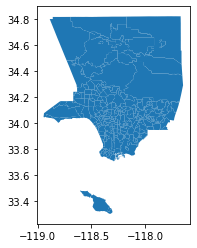

In [40]:
# source: https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr
neighborhoods_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/la_bound_nbhd.geojson'
neighborhoods = gpd.read_file(neighborhoods_dir)
neighborhoods.plot()

In [41]:
neighborhoods.dtypes

external_i      object
name            object
location        object
latitude        object
slug_1          object
sqmi            object
display_na      object
set             object
slug            object
longitude       object
name_1          object
kind            object
type            object
geometry      geometry
dtype: object

In [42]:
# county_boundary_url = 'https://opendata.arcgis.com/datasets/10f1e37c065347e693cf4e8ee753c09b_15.geojson'
# county_boundary = gpd.read_file(county_boundary_url)
# county_boundary.plot()

In [43]:
# This file contains neighborhoods in Orange County as well. Used file saved on laptop downloaded from website (See above).
# url = 'https://github.com/datadesk/mapping-la-data/raw/main/geojson/la-county-neighborhoods-v6.geojson'
# #file = requests.get(url)
# neighborhoods = gpd.read_file(url)
# neighborhoods.head()

<AxesSubplot:>

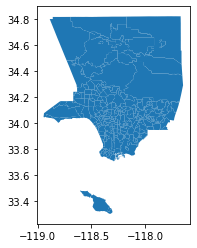

In [44]:
# plot boundaries of neighborhoods for visual check
neighborhoods.plot()

In [45]:
neighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
# Remove Catalina Island (including Avalon) from dataframe
catalina_index = neighborhoods.query('name.str.contains("Catalina") | name.str.contains("Avalon")').index
neighborhoods.drop(catalina_index, inplace=True)

Empty GeoDataFrame
Columns: [external_i, name, location, latitude, slug_1, sqmi, display_na, set, slug, longitude, name_1, kind, type, geometry]
Index: []


<AxesSubplot:>

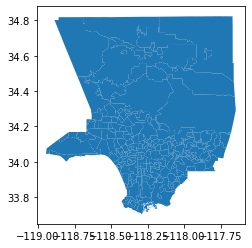

In [47]:
# Check that it was removed
print(neighborhoods.query('name.str.contains("Catalina") | name.str.contains("Avalon")'))
neighborhoods.plot()

In [48]:
#neighborhoods.explore()

## Merge neighborhood boundaries and Energy Atlas data

In [49]:
neighborhoods.head()

,external_i,name,location,latitude,slug_1,sqmi,display_na,set,slug,longitude,name_1,kind,type,geometry
0,acton,Acton,POINT(34.497355239240846 -118.16981019229348),-118.16981019229348,None,39.3391089485,Acton L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),acton,34.497355239240846,None,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894..."
1,adams-normandie,Adams-Normandie,POINT(34.031461499124156 -118.30020800000011),-118.30020800000011,None,0.805350187789,Adams-Normandie L.A. County Neighborhood (Curr...,L.A. County Neighborhoods (Current),adams-normandie,34.031461499124156,None,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.30901 34.03741, -118.3004..."
2,agoura-hills,Agoura Hills,POINT(34.146736499122795 -118.75988450000015),-118.75988450000015,None,8.14676029818,Agoura Hills L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),agoura-hills,34.146736499122795,None,L.A. County Neighborhood (Current),standalone-city,"MULTIPOLYGON (((-118.76193 34.16820, -118.7263..."
3,agua-dulce,Agua Dulce,POINT(34.504926999796837 -118.3171036690717),-118.3171036690717,None,31.4626319451,Agua Dulce L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),agua-dulce,34.504926999796837,None,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.25468 34.55830, -118.2555..."
4,alhambra,Alhambra,POINT(34.085538999123571 -118.13651200000021),-118.13651200000021,None,7.62381430605,Alhambra L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),alhambra,34.085538999123571,None,L.A. County Neighborhood (Current),standalone-city,"MULTIPOLYGON (((-118.12175 34.10504, -118.1168..."


In [50]:
usage_bld_btu

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,name,pop,usage_percap
0,cities_1,1253.0,NaN,NaN,NaN,agriculture,2016,NaN,NaN,agoura hills,NaN,NaN
1,cities_1,4820002.0,3.079439e+11,5.522517e+08,46351.2600,commercial,2016,0.729374,0.270626,agoura hills,NaN,NaN
2,cities_1,8916603.0,3.715327e+11,7.530818e+07,34141.0256,condo,2016,0.401412,0.598588,agoura hills,NaN,NaN
3,cities_1,735816.0,NaN,NaN,NaN,industrial,2016,NaN,NaN,agoura hills,NaN,NaN
4,cities_1,100192.0,NaN,NaN,NaN,institutional,2016,NaN,NaN,agoura hills,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5767,neighborhoods_99,30060.0,NaN,NaN,NaN,residential_other,2016,NaN,NaN,carthay,NaN,NaN
5768,neighborhoods_99,0.0,NaN,NaN,NaN,residential_uncat,2016,NaN,NaN,carthay,NaN,NaN
5769,neighborhoods_99,3452091.0,1.350114e+11,9.211511e+07,35663.1742,res_total,2016,0.325581,0.674419,carthay,5201.0,2.595873e+07
5770,neighborhoods_99,1525718.0,6.178565e+10,7.913064e+07,37415.2632,single_family,2016,0.352719,0.647281,carthay,NaN,NaN


In [51]:
neighborhoods_lower = neighborhoods.copy()
neighborhoods_lower['name'] = neighborhoods_lower['name'].str.lower()
neighborhoods_lower.head()

,external_i,name,location,latitude,slug_1,sqmi,display_na,set,slug,longitude,name_1,kind,type,geometry
0,acton,acton,POINT(34.497355239240846 -118.16981019229348),-118.16981019229348,None,39.3391089485,Acton L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),acton,34.497355239240846,None,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894..."
1,adams-normandie,adams-normandie,POINT(34.031461499124156 -118.30020800000011),-118.30020800000011,None,0.805350187789,Adams-Normandie L.A. County Neighborhood (Curr...,L.A. County Neighborhoods (Current),adams-normandie,34.031461499124156,None,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.30901 34.03741, -118.3004..."
2,agoura-hills,agoura hills,POINT(34.146736499122795 -118.75988450000015),-118.75988450000015,None,8.14676029818,Agoura Hills L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),agoura-hills,34.146736499122795,None,L.A. County Neighborhood (Current),standalone-city,"MULTIPOLYGON (((-118.76193 34.16820, -118.7263..."
3,agua-dulce,agua dulce,POINT(34.504926999796837 -118.3171036690717),-118.3171036690717,None,31.4626319451,Agua Dulce L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),agua-dulce,34.504926999796837,None,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.25468 34.55830, -118.2555..."
4,alhambra,alhambra,POINT(34.085538999123571 -118.13651200000021),-118.13651200000021,None,7.62381430605,Alhambra L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),alhambra,34.085538999123571,None,L.A. County Neighborhood (Current),standalone-city,"MULTIPOLYGON (((-118.12175 34.10504, -118.1168..."


In [52]:
usage_bld = neighborhoods_lower.merge(usage_bld_btu, on='name')
usage_bld.columns

Index(['external_i', 'name', 'location', 'latitude', 'slug_1', 'sqmi',
       'display_na', 'set', 'slug', 'longitude', 'name_1', 'kind', 'type',
       'geometry', 'geo_id', 'sqft', 'usage', 'usage_med', 'usage_med_sqft',
       'usetype', 'year', 'pct_elec', 'pct_ng', 'pop', 'usage_percap'],
      dtype='object')

In [53]:
# clean up dataframe, drop unnecessary columns
cols_drop = ['external_i','slug_1','display_na', 'set', 'name_1']
usage_bld.drop(cols_drop, axis=1, inplace=True)
usage_bld.columns

Index(['name', 'location', 'latitude', 'sqmi', 'slug', 'longitude', 'kind',
       'type', 'geometry', 'geo_id', 'sqft', 'usage', 'usage_med',
       'usage_med_sqft', 'usetype', 'year', 'pct_elec', 'pct_ng', 'pop',
       'usage_percap'],
      dtype='object')

In [54]:
# add column for usage in units of Joules (1 btu = 1055.06 joules)
usage_bld['usage_joules'] = usage_bld['usage']*1055.06

<AxesSubplot:>

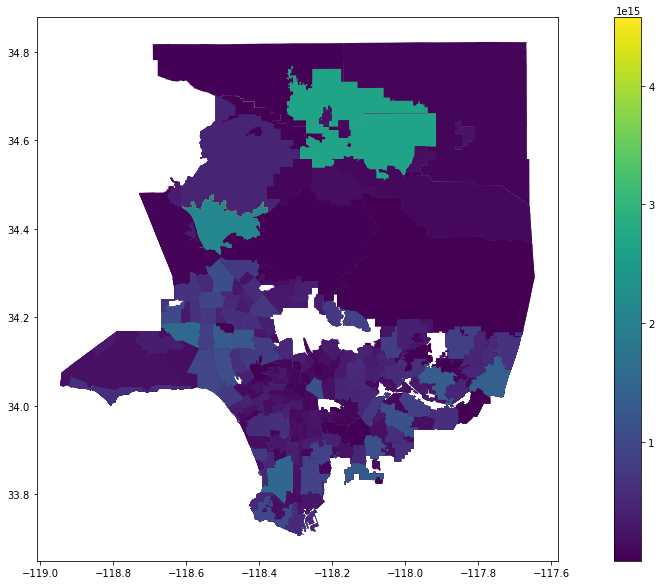

In [55]:
usage_bld.plot(column='usage_joules', legend=True, figsize=(20,10))

In [56]:
# Merge Energy Atlas Electricity only data to neighborhoods
elec_hoods_res = neighborhoods_lower.merge(elec_hoods_res, on='name')
elec_hoods_com = neighborhoods_lower.merge(elec_hoods_com, on='name')
elec_hoods_industrial = neighborhoods_lower.merge(elec_hoods_industrial, on='name')

## Descriptive analysis of Energy Atlas data

In [ ]:
# How many different usetype categories?
usage_bld_btu['usetype'].unique()

In [ ]:
# subset only neighborhood-aggregated records
usage_bld_btu_neighborhoods = usage_bld_btu.loc[usage_bld_btu['geo_id'].str.contains('neighborhoods')].copy()
usage_bld_btu_neighborhoods

In [ ]:
# How many unique neighborhoods?
len(usage_bld_btu_neighborhoods['geo_id'].unique())

In [ ]:
# further subset for only residential
usage_bld_btu_neighborhoods_res = usage_bld_btu_neighborhoods.loc[usage_bld_btu_neighborhoods['usetype'] == 'res_total'].copy()
usage_bld_btu_neighborhoods_res

In [ ]:
print(usage_bld_btu_neighborhoods_res._is_copy)

In [ ]:
# testing SettingWithCopyWarning with test df
df = pd.DataFrame({'A': ['1', '2', 'NaN'], 'B': ['1', 'NaN', '3'], 'C': ['1', '2', '3']})
cols = df.columns.drop(['C'])
df.loc[:, cols] = df[cols].apply(pd.to_numeric, errors = 'coerce')
df

In [ ]:
# convert appropriate columns to numeric
cols = usage_bld_btu_neighborhoods_res.columns.drop(['geo_id', 'usetype', 'name'])
usage_bld_btu_neighborhoods_res.loc[:,cols] = usage_bld_btu_neighborhoods_res[cols].apply(pd.to_numeric, errors = 'coerce')
usage_bld_btu_neighborhoods_res.dtypes

In [ ]:
# distribution of pct_elec
# usage_bld_btu_neighborhoods_res['pct_elec'] = pd.to_numeric(usage_bld_btu_neighborhoods_res['pct_elec'])
usage_bld_btu_neighborhoods_res['pct_elec'].plot.hist(bins = 20) 

In [ ]:
# distribution of pop
usage_bld_btu_neighborhoods_res['pop'].plot.hist(bins = 20) 

In [ ]:
# distribution of usage
usage_bld_btu_neighborhoods_res['usage'].plot.hist(bins = 20) 

In [ ]:
# distribution of usage per capita
usage_bld_btu_neighborhoods_res['usage_percap'].plot.hist(bins = 20) 

## Create 2d grid

In [ ]:
"""
example references:
https://james-brennan.github.io/posts/fast_gridding_geopandas/
https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python
"""

# create grid that covers the extent of LA County, set at 'X' m resolution
xmin, ymin, xmax, ymax= neighborhoods.total_bounds

# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)
to_original_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((xmin, ymin))
ne = shapely.geometry.Point((xmax, ymax))

stepsize = 1000 # grid resolution in meters

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE



In [ ]:
print(xmin, ymin, xmax, ymax)

In [ ]:
# Iterate over 2D area
grid_cells = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        x1 = x + stepsize
        y1 = y + stepsize
        cell = shapely.geometry.box(x, y, x1, y1)
        grid_cells.append(cell)
        y += stepsize
    x += stepsize


ah_grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='epsg:3857')
ah_grid = ah_grid.to_crs('epsg:4326')

ax = neighborhoods.plot(figsize=(24, 16))
plt.autoscale(False)
#ah_grid.plot(ax=ax, facecolor="none", edgecolor='grey')

## Anthropogenic heat flux from residential buildings

### Test case 1: University Park neighborhood

In [ ]:
# get usage for university park neighborhood only
usage_usc = usage_bld[(usage_bld['name'] == 'university park') & (usage_bld['usetype'] == 'res_total')]
#usage_usc = usage_bld[usage_bld['usetype'] == 'res_total']
ax = usage_usc.plot(figsize=(10,10), column = 'usage_joules', alpha=0.1, edgecolor='k')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
#ax.annotate(usage_usc.iloc[0].usage_joules, xy=[pd.to_numeric(top_row['latitude']), pd.to_numeric(top_row['longitude'])])
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=usage_bld.crs) # notice the crs must match between basemap and data

In [ ]:
# create 2d grid
"""
example references:
https://james-brennan.github.io/posts/fast_gridding_geopandas/
https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python
"""

# create grid that covers the extent of LA County, set at 'X' m resolution
xmin, ymin, xmax, ymax = usage_usc.total_bounds

# create a little buffer for extent
xmin = xmin - 0.005
ymin = ymin - 0.005
xmax = xmax + 0.005
ymax = ymax + 0.005

# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)
to_original_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((xmin, ymin))
ne = shapely.geometry.Point((xmax, ymax))

stepsize = 100 # grid resolution in meters

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE

# Iterate over 2D area
grid_cells = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        x1 = x + stepsize
        y1 = y + stepsize
        cell = shapely.geometry.box(x, y, x1, y1)
        grid_cells.append(cell)
        y += stepsize
    x += stepsize


ah_grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='epsg:3857')
ah_grid = ah_grid.to_crs('epsg:4326')

ax = usage_usc.plot(figsize=(10,10), alpha=0.1, edgecolor='k')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=usage_bld.crs) # notice the crs must match between basemap and data
ah_grid.plot(ax=ax, facecolor="none", edgecolor='grey')

In [ ]:
# spatial join LARIAC and parcels dataframe
parcels_usc_res_df = parcels_usc_df[parcels_usc_df['UseType'] == 'Residential'].copy() # filter for only residential
parcels_usc_res_df.drop_duplicates('geometry', inplace=True) # !!!REMOVE DUPLICATE PARCELS!!!
lariac_usc_merged_inner = gpd.sjoin(lariac_usc_df, parcels_usc_res_df, how='inner')

# plot to visualize
ax = lariac_usc_merged_inner.plot(figsize=(10,10), alpha=0.5, facecolor = 'none', edgecolor='blue')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
ah_grid.plot(ax=ax, facecolor="none", edgecolor='gray')
usage_usc.plot(ax=ax, alpha=0.1, edgecolor='k')

In [ ]:
# spatial join the 2d grid and the neighborhood boundary
grid_usc = gpd.sjoin(ah_grid, usage_usc)
# plot to visualize
ax = lariac_usc_merged_inner.plot(figsize=(10,10), alpha=0.5, facecolor = 'none', edgecolor='blue')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
usage_usc.plot(ax=ax, alpha=0.1, edgecolor='k')

In [ ]:
# drop columns with 'index_*'
grid_usc.drop(list(grid_usc.filter(regex = 'index_')), axis=1, inplace=True)
lariac_usc_merged_inner.drop(list(lariac_usc_merged_inner.filter(regex = 'index_')), axis=1, inplace=True)
# add extra geometry column to save grid geometry for spatial joins
grid_usc['grid_geometry'] = grid_usc.geometry
# make the index a column
grid_usc.reset_index(inplace=True)
# rename index to grid_cell_index
grid_usc.rename(columns={'index':'grid_cell_index'}, inplace=True)

In [ ]:
grid_usc.head()

In [ ]:
# spatial join buildings and grid (intersects)
buildings_usc_intersects = gpd.sjoin(lariac_usc_merged_inner, grid_usc, predicate='intersects')
# plot to visualize
ax = buildings_usc_intersects.plot(figsize=(10,10), alpha=0.5, facecolor = 'none', edgecolor='blue')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
usage_usc.plot(ax=ax, alpha=0.1, edgecolor='k')              

In [ ]:
# # spatial join buildings and grid (within)
# buildings_usc_within = gpd.sjoin(lariac_usc_merged_inner, grid_usc, predicate='within')
# # plot to visualize
# ax = grid_usc.plot(figsize=(10,10), facecolor="none", edgecolor='blue')
# ax.get_xaxis().get_major_formatter().set_useOffset(False)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
# buildings_usc_within.plot(ax=ax, alpha=0.5, facecolor = 'yellow', edgecolor='red')
# usage_usc.plot(ax=ax, alpha=0.1, edgecolor='k')       

In [ ]:
# # spatial join buildings and grid (Switch left/right order this time)
# grid_usc_intersects = gpd.sjoin(grid_usc, lariac_usc_merged_inner, predicate='intersects')
# # plot to visualize
# ax = grid_usc_intersects.plot(figsize=(10,10), alpha=0.5, facecolor = 'yellow', edgecolor='red')
# ax.get_xaxis().get_major_formatter().set_useOffset(False)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
# grid_usc.plot(ax=ax, facecolor="none", edgecolor='blue')
# usage_usc.plot(ax=ax, alpha=0.1, edgecolor='k')  

In [ ]:
buildings_usc_intersects.grid_geometry.plot(facecolor="none", edgecolor='blue')

In [ ]:
len(buildings_usc_intersects.grid_geometry.unique())

In [ ]:
#testing overlay 
buildings_usc_overlay_intersection = lariac_usc_merged_inner.overlay(grid_usc, how='intersection')
# plot to visualize
#buildings_usc_overlay_intersection.explore()

In [ ]:
# total building area in this neighborhood?
total_building_area_usc = buildings_usc_overlay_intersection['AREA'].sum()
total_building_area_usc

In [ ]:
# calculate building volume and add as a new column
buildings_usc_overlay_intersection['VOLUME'] = buildings_usc_overlay_intersection['AREA']*buildings_usc_overlay_intersection['HEIGHT'] # units: cubic feet

In [ ]:
#buildings_usc_overlay_intersection.shape

In [ ]:
#len(buildings_usc_overlay_intersection['lariac_id'].unique())

In [ ]:
# add column that describes the fraction of the whole building that segment represents
buildings_usc_overlay_intersection['building_fraction'] = buildings_usc_overlay_intersection.to_crs('epsg:3857').geometry.area/buildings_usc_overlay_intersection['shape_area_whole']
buildings_usc_overlay_intersection['VOLUME'] = buildings_usc_overlay_intersection['building_fraction']*buildings_usc_overlay_intersection['VOLUME']
#buildings_usc_overlay_intersection

In [ ]:
# total building area in this neighborhood?
total_building_vol_usc = buildings_usc_overlay_intersection['VOLUME'].sum()
total_building_vol_usc

In [ ]:
# df of total building volume in each grid cell
building_volume_df = buildings_usc_overlay_intersection[['grid_cell_index', 'VOLUME']]
volume_by_cell = building_volume_df.groupby('grid_cell_index').sum()
# make the index a column
volume_by_cell.reset_index(inplace=True)

In [ ]:
# add cells with no buildings 
volume_by_cell_all = volume_by_cell.merge(grid_usc, how='outer') # outer join
volume_by_cell_all = volume_by_cell_all[['grid_cell_index','VOLUME','pct_elec','usage_joules','grid_geometry']] # only keep these columns
volume_by_cell_all.head()

In [ ]:
# calculate volume-based weights and finally, the AHF
cell_area = stepsize**2 # area of single cell; stepsize is resolution in meters (defined above)
n_cells = len(grid_usc) # number of total cells in neighborhood
seconds_in_year = 3.154e+7
ahf = gpd.GeoDataFrame(volume_by_cell_all, geometry='grid_geometry')
ahf['VOLUME'] = ahf['VOLUME'].fillna(0)
ahf['vol_frac'] = ahf['VOLUME']/total_building_vol_usc
ahf['electricity_use'] = ahf['pct_elec']*ahf['usage_joules']*ahf['vol_frac']
ahf['ahf'] = ahf['electricity_use']/cell_area/seconds_in_year
ahf

In [ ]:
# plot to visualize
ax = ahf.plot(figsize=(10,10), column='ahf', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_intersects.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [ ]:
# plot AHF with naive averaging (i.e., no building volume weights)
ahf['electricity_use_naive'] = (ahf['pct_elec']*ahf['usage_joules'])/n_cells
ahf['ahf_naive'] = ahf['electricity_use_naive']/cell_area/seconds_in_year

In [ ]:
# plot to visualize
ax = ahf.plot(figsize=(10,10), column='ahf_naive', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6,legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_intersects.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

### Test case 2: University Park and Adams-Normandie

In [ ]:
# create mask for two neighborhoods
neighborhoods_2 = neighborhoods[(neighborhoods['name']=='University Park') | (neighborhoods['name']=='Adams-Normandie')]
neighborhoods_2

In [ ]:
%%time
# load subset of parcels using mask                              
parcels_2_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/LA_County_Parcels-shp.zip'
parcels_2_df = gpd.read_file(parcels_2_dir, na_values = ['masked'], mask = neighborhoods_2)
parcels_2_df.plot()

In [ ]:
%%time
# loading all lariac data as geojson                       
lariac_2_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017.geojson'
lariac_2_df = gpd.read_file(lariac_2_dir)#, mask = neighborhoods_2)

In [ ]:
%%time
# loading all lariac data as gdb                       
lariac_2_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017.gdb'
lariac_2_df = gpd.read_file(lariac_2_dir)#, mask = neighborhoods_2)

In [ ]:
# convert to feather 
geofeather.to_geofeather(lariac_2_df, '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017.feather')

In [ ]:
%%time
# read feather file
lariac_all_df = geofeather.from_geofeather('/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017.feather')

In [ ]:
%%time
# load all parcels                            
parcels_2_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/LA_County_Parcels.geojson'
parcels_2_df = gpd.read_file(parcels_2_dir)

In [ ]:
%%time
# convert parcels to feather 
geofeather.to_geofeather(lariac_2_df, '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017.feather')

In [ ]:
%%time
# read parcels feather file
lariac_all_df = geofeather.from_geofeather('/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017.feather')

In [ ]:
# rename OBJECTID to avoid duplicate column names
lariac_2_df.rename(columns={'OBJECTID':'lariac_id'}, inplace=True)
parcels_2_df.rename(columns={'OBJECTID':'parcel_id'}, inplace=True)

# keep only columns listed above
lariac_2_df = lariac_2_df[lariac_columns].copy()
parcels_2_df = parcels_2_df[parcels_columns].copy()

# calculate shape area from geometry in units of meters squared
lariac_2_df['shape_area_whole'] = lariac_2_df.to_crs('epsg:3857').geometry.area

# delete courtyards, keep only buildings
lariac_2_df.drop(lariac_2_df[lariac_2_df['CODE']=='Courtyard'].index, inplace=True)

In [ ]:
# get usage for university park neighborhood only
usage_usc = usage_bld[((usage_bld['name'] == 'adams-normandie') |
                      (usage_bld['name'] == 'university park')) &
                      (usage_bld['usetype'] == 'res_total')]
#usage_usc = usage_bld[usage_bld['usetype'] == 'res_total']
ax = usage_usc.plot(figsize=(10,10), column = 'usage_joules', alpha=0.1, edgecolor='k')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
#ax.annotate(usage_usc.iloc[0].usage_joules, xy=[pd.to_numeric(top_row['latitude']), pd.to_numeric(top_row['longitude'])])
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=usage_bld.crs) # notice the crs must match between basemap and data

### Test Case 3: Central LA chunk

In [13]:
# Import LARIAC and parcels data 
lariac_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/test_case_central_la/buildings.gpkg'
lariac_df = gpd.read_file(lariac_dir)

parcels_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/test_case_central_la/parcels.gpkg'
parcels_df = gpd.read_file(parcels_dir, na_values = ['masked'])

# rename OBJECTID to avoid duplicate column names
lariac_df.rename(columns={'OBJECTID':'lariac_id'}, inplace=True)
parcels_df.rename(columns={'OBJECTID':'parcel_id'}, inplace=True)

# choose columns to keep
lariac_columns = ['lariac_id',
 'CODE',
 'BLD_ID',
 'HEIGHT',
 'ELEV',
 'DATE_',
 'STATUS',
 'AREA',
 'geometry']

parcels_columns = ['parcel_id',
 'AIN',
 'APN',
 'UseType',
 'UseDescrip',
 'DesignType',
 'CENTER_LAT',
 'CENTER_LON',
 'CENTER_X',
 'CENTER_Y',
 'LAT_LON',
 'ShapeSTAre',
 'ShapeSTLen',
 'geometry']

# keep only columns listed above
lariac_df = lariac_df[lariac_columns]
parcels_df = parcels_df[parcels_columns]

# calculate shape area from geometry in units of meters squared
lariac_df['shape_area_whole'] = lariac_df.to_crs('epsg:3857').geometry.area

# delete courtyards, keep only buildings
lariac_df.drop(lariac_df[lariac_df['CODE']=='Courtyard'].index, inplace=True)

<AxesSubplot:>

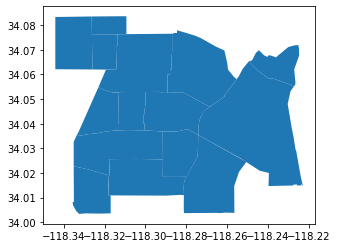

In [57]:
# import the set of neighborhoods to be used in this test case
hoods_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/test_case_central_la/neighborhoods.gpkg'
hoods_df = gpd.read_file(hoods_dir)
hoods_df.plot()

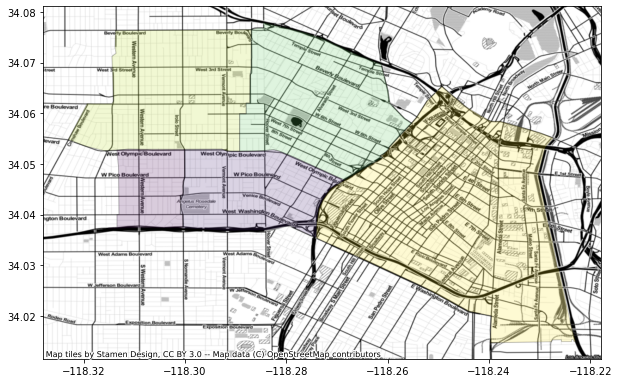

In [92]:
# get usage for university park neighborhood only
usage = elec_hoods_res[(elec_hoods_res['name'] == 'downtown') |
                      (elec_hoods_res['name'] == 'koreatown') |
                      (elec_hoods_res['name'] == 'westlake') |
                      (elec_hoods_res['name'] == 'pico-union') |
                      (elec_hoods_res['name'] == 'harvard heights')]
# usage_res = usage[(usage['usetype'] == 'res_total')].copy()
# usage_com = usage[(usage['usetype'] == 'commercial')].copy()

ax = usage.plot(figsize=(10,10), column = 'usage', alpha=0.2, edgecolor='k')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=elec_hoods_res.crs) # notice the crs must match between basemap and data

<AxesSubplot:>

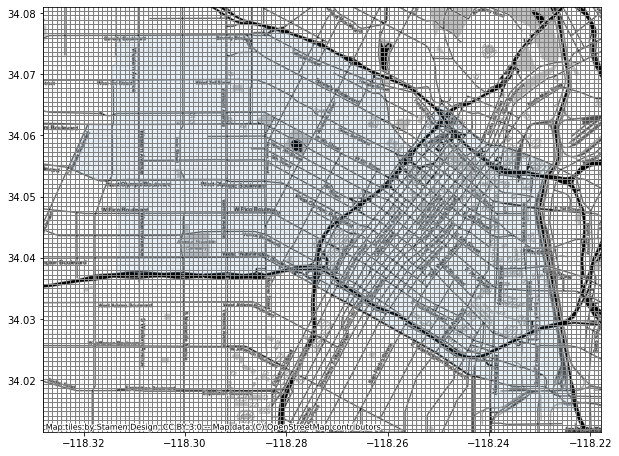

In [59]:
# create 2d grid
"""
example references:
https://james-brennan.github.io/posts/fast_gridding_geopandas/
https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python
"""

# create grid that covers the extent of LA County, set at 'X' m resolution
xmin, ymin, xmax, ymax = usage.total_bounds

# create a little buffer for extent
xmin = xmin - 0.005
ymin = ymin - 0.005
xmax = xmax + 0.005
ymax = ymax + 0.005

# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)
to_original_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((xmin, ymin))
ne = shapely.geometry.Point((xmax, ymax))

stepsize = 100 # grid resolution in meters

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE

# Iterate over 2D area
grid_cells = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        x1 = x + stepsize
        y1 = y + stepsize
        cell = shapely.geometry.box(x, y, x1, y1)
        grid_cells.append(cell)
        y += stepsize
    x += stepsize


ah_grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='epsg:3857')
ah_grid = ah_grid.to_crs('epsg:4326')

ax = usage.plot(figsize=(10,10), alpha=0.1, edgecolor='k')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=elec_hoods_res.crs) # notice the crs must match between basemap and data
ah_grid.plot(ax=ax, facecolor="none", edgecolor='grey')

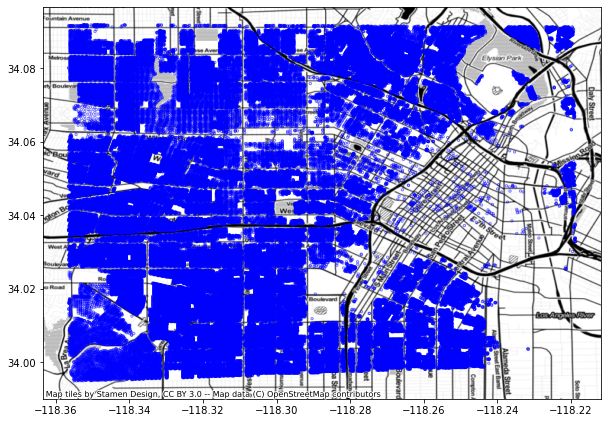

In [93]:
# spatial join LARIAC and parcels dataframe
parcels_res_df = parcels_df[parcels_df['UseType'] == 'Residential'].copy() # filter for only residential
parcels_res_df.drop_duplicates('geometry', inplace=True) # !!!REMOVE DUPLICATE PARCELS!!!
lariac_centroids_df = lariac_df.copy()
lariac_centroids_df['centroids'] = lariac_centroids_df.geometry.to_crs('epsg:3857').centroid
lariac_centroids_df.set_geometry('centroids', inplace=True)
lariac_centroids_df = lariac_centroids_df.to_crs('epsg:4326')
lariac_merged_inner = lariac_centroids_df.sjoin(parcels_res_df, how='inner', predicate = 'within')
#lariac_merged_inner = lariac_df.sjoin(parcels_res_df, how='inner', predicate = 'within')
#lariac_merged_inner = lariac_df.sjoin_nearest(parcels_res_df, how='inner', max_distance=0.001)

# plot to visualize
ax = lariac_merged_inner.plot(figsize=(10,10), alpha=0.5, color='blue', facecolor='none', marker='o', markersize = 5)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_merged_inner.crs) # notice the crs must match between basemap and data
#ah_grid.plot(ax=ax, facecolor="none", edgecolor='gray')
#usage.plot(ax=ax, alpha=0.1, edgecolor='k')

In [94]:
lariac_merged_inner.set_geometry('geometry', inplace=True)

In [95]:
# spatial join the 2d grid and the neighborhood boundary
grid = ah_grid.overlay(usage, how='intersection')

# # plot to visualize
# ax = lariac_merged_inner.plot(figsize=(10,10), alpha=0.5, facecolor = 'none', edgecolor='blue')
# ax.get_xaxis().get_major_formatter().set_useOffset(False)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_merged_inner.crs) # notice the crs must match between basemap and data
# grid.plot(ax=ax, facecolor="none", edgecolor='gray')
# usage_res.plot(ax=ax, alpha=0.1, edgecolor='k')

In [96]:
# drop columns with 'index_*'
grid.drop(list(grid.filter(regex = 'index_')), axis=1, inplace=True)
lariac_merged_inner.drop(list(lariac_merged_inner.filter(regex = 'index_')), axis=1, inplace=True)

# add extra geometry column to save grid geometry for spatial joins
grid['grid_geometry'] = grid.geometry

# make the index a column
grid.reset_index(inplace=True)
# rename index to grid_cell_index
grid.rename(columns={'index':'grid_cell_index'}, inplace=True)

In [97]:
# overlay bulding footprints and grid
buildings_overlay_intersection = lariac_merged_inner.overlay(grid, how='intersection')


In [98]:
# calculate building volume and add as a new column (whole building, not segment of building)
buildings_overlay_intersection['VOLUME'] = buildings_overlay_intersection['AREA']*buildings_overlay_intersection['HEIGHT'] # units: cubic feet

# add column that describes the fraction of the whole building that segment represents
buildings_overlay_intersection['building_fraction'] = buildings_overlay_intersection.to_crs('epsg:3857').geometry.area/buildings_overlay_intersection['shape_area_whole']
buildings_overlay_intersection['VOLUME'] = buildings_overlay_intersection['building_fraction']*buildings_overlay_intersection['VOLUME']

# create column for total volume in that neighborhood
buildings_overlay_intersection['total_volume'] = buildings_overlay_intersection['VOLUME'].groupby(buildings_overlay_intersection['name']).transform('sum')


In [99]:
# df of total building volume in each grid cell
building_volume_df = buildings_overlay_intersection[['grid_cell_index', 'VOLUME']]
volume_by_cell = building_volume_df.groupby('grid_cell_index').sum()
# make the index a column
volume_by_cell.reset_index(inplace=True)

# add cells with no buildings 
volume_by_cell_all = volume_by_cell.merge(grid, how='outer') # outer join
volume_by_cell_all = volume_by_cell_all[['grid_cell_index','VOLUME', 'name',
                                         'usage','grid_geometry']] # only keep these columns
total_volumes = buildings_overlay_intersection[['name', 'total_volume']].copy()
total_volumes.drop_duplicates(inplace=True)
volume_by_cell_all = volume_by_cell_all.merge(total_volumes, how='outer')

Filter columns to reduce clutter

In [100]:
# calculate volume-based weights and finally, the AHF
cell_area = stepsize**2 # area of single cell; stepsize is resolution in meters (defined above)
n_cells = len(grid) # number of total cells in neighborhood
seconds_in_year = 3.154e+7
ahf = gpd.GeoDataFrame(volume_by_cell_all, geometry='grid_geometry')
ahf['VOLUME'] = ahf['VOLUME'].fillna(0)
ahf['vol_frac'] = ahf['VOLUME']/ahf['total_volume']
ahf['electricity_use'] = ahf['usage']*ahf['vol_frac']*3.6*(10**6) # convert kwh to joules
ahf['ahf'] = ahf['electricity_use']/cell_area/seconds_in_year
ahf.head()

,grid_cell_index,VOLUME,name,usage,grid_geometry,total_volume,vol_frac,electricity_use,ahf
0,3,216805.342849,koreatown,173523361.0,"POLYGON ((-118.32262 34.05512, -118.32172 34.0...",7.237845e+08,2.995440e-04,1.871204e+11,0.593280
1,4,270122.094681,koreatown,173523361.0,"POLYGON ((-118.32172 34.05586, -118.32172 34.0...",7.237845e+08,3.732079e-04,2.331370e+11,0.739179
2,5,371712.948593,koreatown,173523361.0,"POLYGON ((-118.32172 34.05661, -118.32172 34.0...",7.237845e+08,5.135685e-04,3.208181e+11,1.017178
3,6,353.352543,koreatown,173523361.0,"POLYGON ((-118.32172 34.05661, -118.32207 34.0...",7.237845e+08,4.882013e-07,3.049716e+08,0.000967
4,8,406436.340734,koreatown,173523361.0,"POLYGON ((-118.32172 34.05437, -118.32172 34.0...",7.237845e+08,5.615433e-04,3.507872e+11,1.112198


In [101]:
# convert values of zero to NA
ahf['ahf'].replace(0, np.nan, inplace=True)

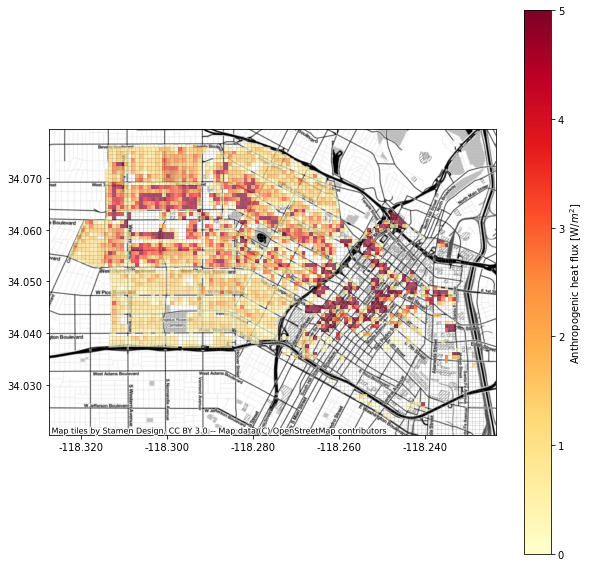

In [102]:
# plot to visualize
ax = ahf.plot(figsize=(10,10), column='ahf', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=5, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_merged_inner.crs) # notice the crs must match between basemap and data
grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [ ]:
ahf.dtypes

In [ ]:
# export ahf as shapefile
ahf.to_file('./data/output/ahf_central_la_res.shp')

### Test Case 4: Generic Neighborhood

In [ ]:
# Import LARIAC and parcels data 
lariac_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/test_case_central_la/buildings.gpkg'
lariac_df = gpd.read_file(lariac_dir)

parcels_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/test_case_central_la/parcels.gpkg'
parcels_df = gpd.read_file(parcels_dir, na_values = ['masked'])

# rename OBJECTID to avoid duplicate column names
lariac_df.rename(columns={'OBJECTID':'lariac_id'}, inplace=True)
parcels_df.rename(columns={'OBJECTID':'parcel_id'}, inplace=True)

# choose columns to keep
lariac_columns = ['lariac_id',
 'CODE',
 'BLD_ID',
 'HEIGHT',
 'ELEV',
 'DATE_',
 'STATUS',
 'AREA',
 'geometry']

parcels_columns = ['parcel_id',
 'AIN',
 'APN',
 'UseType',
 'UseDescrip',
 'DesignType',
 'CENTER_LAT',
 'CENTER_LON',
 'CENTER_X',
 'CENTER_Y',
 'LAT_LON',
 'ShapeSTAre',
 'ShapeSTLen',
 'geometry']

# keep only columns listed above
lariac_df = lariac_df[lariac_columns]
parcels_df = parcels_df[parcels_columns]

# calculate shape area from geometry in units of meters squared
lariac_df['shape_area_whole'] = lariac_df.to_crs('epsg:3857').geometry.area

# delete courtyards, keep only buildings
lariac_df.drop(lariac_df[lariac_df['CODE']=='Courtyard'].index, inplace=True)

# spatial join LARIAC and parcels dataframe
parcels_res_df = parcels_df[parcels__df['UseType'] == 'Residential'].copy() # filter for only residential
parcels_res_df.drop_duplicates('geometry', inplace=True) # !!!REMOVE DUPLICATE PARCELS!!!
lariac_merged_inner = gpd.sjoin(lariac_df, parcels_res_df, how='inner')

In [ ]:
# get usage for university park neighborhood only
usage = usage_bld[(usage_bld['name'] == 'pico-union') & (usage_bld['usetype'] == 'res_total')]

# === create 2d grid === 
# create grid that covers the extent of LA County, set at 'X' m resolution
xmin, ymin, xmax, ymax = usage.total_bounds

# create a little buffer for extent
xmin = xmin - 0.005
ymin = ymin - 0.005
xmax = xmax + 0.005
ymax = ymax + 0.005

# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)
to_original_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((xmin, ymin))
ne = shapely.geometry.Point((xmax, ymax))

stepsize = 100 # grid resolution in meters

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE

# Iterate over 2D area
grid_cells = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        x1 = x + stepsize
        y1 = y + stepsize
        cell = shapely.geometry.box(x, y, x1, y1)
        grid_cells.append(cell)
        y += stepsize
    x += stepsize

ah_grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='epsg:3857')
ah_grid = ah_grid.to_crs('epsg:4326')

# spatial join the 2d grid and the neighborhood boundary
grid = ah_grid.overlay(usage, how='intersection')

# drop columns with 'index_*'
grid.drop(list(grid.filter(regex = 'index_')), axis=1, inplace=True)
lariac_merged_inner.drop(list(lariac_merged_inner.filter(regex = 'index_')), axis=1, inplace=True)

# add extra geometry column to save grid geometry for spatial joins
grid['grid_geometry'] = grid.geometry

# make the index a column
grid.reset_index(inplace=True)
# rename index to grid_cell_index
grid.rename(columns={'index':'grid_cell_index'}, inplace=True)

# overlay bulding footprints and grid
buildings_overlay_intersection = lariac_merged_inner.overlay(grid, how='intersection')

# calculate building volume and add as a new column (whole building, not segment of building)
buildings_overlay_intersection['VOLUME'] = buildings_overlay_intersection['AREA']*buildings_overlay_intersection['HEIGHT'] # units: cubic feet

# add column that describes the fraction of the whole building that segment represents
buildings_overlay_intersection['building_fraction'] = buildings_overlay_intersection.to_crs('epsg:3857').geometry.area/buildings_overlay_intersection['shape_area_whole']
buildings_overlay_intersection['VOLUME'] = buildings_overlay_intersection['building_fraction']*buildings_overlay_intersection['VOLUME']

# create column for total volume in that neighborhood
buildings_overlay_intersection['total_volume'] = buildings_overlay_intersection['VOLUME'].groupby(buildings_overlay_intersection['name']).transform('sum')

# df of total building volume in each grid cell
building_volume_df = buildings_overlay_intersection[['grid_cell_index', 'VOLUME']]
volume_by_cell = building_volume_df.groupby('grid_cell_index').sum()
# make the index a column
volume_by_cell.reset_index(inplace=True)

# add cells with no buildings 
volume_by_cell_all = volume_by_cell.merge(grid, how='outer') # outer join
volume_by_cell_all = volume_by_cell_all[['grid_cell_index','VOLUME', 'name',
                                         'pct_elec','usage_joules','grid_geometry']] # only keep these columns
total_volumes = buildings_overlay_intersection[['name', 'total_volume']].copy()
total_volumes.drop_duplicates(inplace=True)
volume_by_cell_all = volume_by_cell_all.merge(total_volumes, how='outer')

# calculate volume-based weights and finally, the AHF
cell_area = stepsize**2 # area of single cell; stepsize is resolution in meters (defined above)
n_cells = len(grid) # number of total cells in neighborhood
seconds_in_year = 3.154e+7
ahf = gpd.GeoDataFrame(volume_by_cell_all, geometry='grid_geometry')
ahf['VOLUME'] = ahf['VOLUME'].fillna(0)
ahf['vol_frac'] = ahf['VOLUME']/ahf['total_volume']
ahf['electricity_use'] = ahf['pct_elec']*ahf['usage_joules']*ahf['vol_frac']
ahf['ahf'] = ahf['electricity_use']/cell_area/seconds_in_year
ahf

In [ ]:
# plot to visualize
ax = ahf.plot(figsize=(10,10), column='ahf', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=5, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_merged_inner.crs) # notice the crs must match between basemap and data
grid.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_overlay_intersection.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

## Anthropogenic heat flux from commercial buildings

### Proof of concept: University Park neighborhood

In [ ]:
usage_bld['usetype'].unique()

In [ ]:
# get usage for university park neighborhood only
usage_usc_com = usage_bld[(usage_bld['name'] == 'university park') & (usage_bld['usetype'] == 'commercial')]

In [ ]:
usage_usc_com.head()

In [ ]:
# spatial join LARIAC and parcels dataframe
parcels_usc_com_df = parcels_usc_df[parcels_usc_df['UseType'] == 'Commercial'].copy() # filter for only commercial
parcels_usc_com_df.drop_duplicates('geometry', inplace=True) # !!!REMOVE DUPLICATE PARCELS!!!
#lariac_usc_merged_inner_com = gpd.sjoin(lariac_usc_df, parcels_usc_com_df, how='inner')
lariac_usc_merged_inner_com = lariac_usc_df.overlay(parcels_usc_com_df, how='intersection')

# spatial join the 2d grid and the neighborhood boundary
grid_usc_com = gpd.sjoin(ah_grid, usage_usc_com)

# plot to visualize
ax = lariac_usc_merged_inner_com.plot(figsize=(10,10), alpha=0.5, facecolor = 'none', edgecolor='blue')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
ah_grid.plot(ax=ax, facecolor="none", edgecolor='gray')
usage_usc_com.plot(ax=ax, alpha=0.1, edgecolor='k')

In [ ]:
# drop columns with 'index_*'
lariac_usc_merged_inner_com.drop(list(lariac_usc_merged_inner_com.filter(regex = 'index_')), axis=1, inplace=True)
grid_usc_com.drop(list(grid_usc.filter(regex = 'index_')), axis=1, inplace=True)
# add extra geometry column to save grid geometry for spatial joins
grid_usc_com['grid_geometry'] = grid_usc_com.geometry
# make the index a column
grid_usc_com.reset_index(inplace=True)
# rename index to grid_cell_index
grid_usc_com.rename(columns={'index':'grid_cell_index'}, inplace=True)

In [ ]:
#testing overlay 
buildings_usc_overlay_intersection_com = lariac_usc_merged_inner_com.overlay(grid_usc_com, how='intersection')
# plot to visualize
#buildings_usc_overlay_intersection_com.explore()

In [ ]:
# total building area in this neighborhood?
total_building_area_usc_com = buildings_usc_overlay_intersection_com['AREA'].sum()

# calculate building volume and add as a new column
buildings_usc_overlay_intersection_com['VOLUME'] = buildings_usc_overlay_intersection_com['AREA']*buildings_usc_overlay_intersection_com['HEIGHT'] # units: cubic feet

# add column that describes the fraction of the whole building that segment represents
buildings_usc_overlay_intersection_com['building_fraction'] = buildings_usc_overlay_intersection_com.to_crs('epsg:3857').geometry.area/buildings_usc_overlay_intersection_com['shape_area_whole']
buildings_usc_overlay_intersection_com['VOLUME'] = buildings_usc_overlay_intersection_com['building_fraction']*buildings_usc_overlay_intersection_com['VOLUME']

# total building area in this neighborhood?
total_building_vol_usc_com = buildings_usc_overlay_intersection_com['VOLUME'].sum()

# df of total building volume in each grid cell
building_volume_df_com = buildings_usc_overlay_intersection_com[['grid_cell_index', 'VOLUME']]
volume_by_cell_com = building_volume_df_com.groupby('grid_cell_index').sum()
# make the index a column
volume_by_cell_com.reset_index(inplace=True)

# add cells with no buildings 
volume_by_cell_all_com = volume_by_cell_com.merge(grid_usc_com, how='outer') # outer join
volume_by_cell_all_com = volume_by_cell_all_com[['grid_cell_index','VOLUME','pct_elec','usage_joules','grid_geometry']] # only keep these columns

In [ ]:
building_volume_df_com[building_volume_df_com['grid_cell_index']==687]

In [ ]:
# calculate volume-based weights and finally, the AHF
ahf_com = gpd.GeoDataFrame(volume_by_cell_all_com, geometry='grid_geometry')
ahf_com['VOLUME'] = ahf_com['VOLUME'].fillna(0)
ahf_com['vol_frac'] = ahf_com['VOLUME']/total_building_vol_usc_com
ahf_com['electricity_use'] = ahf_com['pct_elec']*ahf_com['usage_joules']*ahf_com['vol_frac']
ahf_com['ahf'] = ahf_com['electricity_use']/cell_area/seconds_in_year
ahf_com

In [ ]:
ahf_com[ahf_com['ahf']>20]

In [ ]:
ahf_com.head()

In [ ]:
# plot to visualize
ax = ahf_com.plot(figsize=(10,10), column='ahf', alpha=0.7, legend=True, cmap='YlOrRd')#, vmin=0, vmax=5, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc_com.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_overlay_intersection_com.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.4)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [ ]:
"""
I noticed that some AHF values for some cells seemed to be suspiciously large.
Turns out this is due to mixed-use buildings and some parking lots included as commercial structures. 
Temporary solution: weight by building footprint instead of volume until more permanent solution.
"""
# === Weight by area ===
# total building area in this neighborhood?
total_building_area_usc_com = buildings_usc_overlay_intersection_com['AREA'].sum()

# add column that describes the fraction of the whole building that segment represents
buildings_usc_overlay_intersection_com['building_fraction'] = buildings_usc_overlay_intersection_com.to_crs('epsg:3857').geometry.area/buildings_usc_overlay_intersection_com['shape_area_whole']
buildings_usc_overlay_intersection_com['AREA'] = buildings_usc_overlay_intersection_com['building_fraction']*buildings_usc_overlay_intersection_com['AREA']

# df of total building volume in each grid cell
building_area_df_com = buildings_usc_overlay_intersection_com[['grid_cell_index', 'AREA']]
area_by_cell_com = building_area_df_com.groupby('grid_cell_index').sum()
# make the index a column
area_by_cell_com.reset_index(inplace=True)

# add cells with no buildings 
area_by_cell_all_com = area_by_cell_com.merge(grid_usc_com, how='outer') # outer join
area_by_cell_all_com = area_by_cell_all_com[['grid_cell_index','AREA','pct_elec','usage_joules','grid_geometry']] # only keep these columns

In [ ]:
# calculate AREA-based weights and finally, the AHF
ahf_com['AREA'] = area_by_cell_all_com['AREA']
ahf_com['AREA'] = ahf_com['AREA'].fillna(0)
ahf_com['area_frac'] = ahf_com['AREA']/total_building_area_usc_com
ahf_com['electricity_use_area_weighted'] = ahf_com['pct_elec']*ahf_com['usage_joules']*ahf_com['area_frac']
ahf_com['ahf_area_weighted'] = ahf_com['electricity_use_area_weighted']/cell_area/seconds_in_year
ahf_com.head()

In [ ]:
# plot to visualize
ax = ahf_com.plot(figsize=(10,10), column='ahf_area_weighted', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc_com.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_overlay_intersection_com.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.4)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [ ]:
ahf.head()

In [ ]:
ahf_com.head()

In [ ]:
# plot AHF with naive averaging (i.e., no building volume weights)
ahf_com['electricity_use_naive'] = (ahf_com['pct_elec']*ahf_com['usage_joules'])/n_cells
ahf_com['ahf_naive'] = ahf_com['electricity_use_naive']/cell_area/seconds_in_year
ax = ahf_com.plot(figsize=(10,10), column='ahf_naive', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6,legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc_com.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_overlay_intersection_com.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

### Test case 3: Central LA Chunk

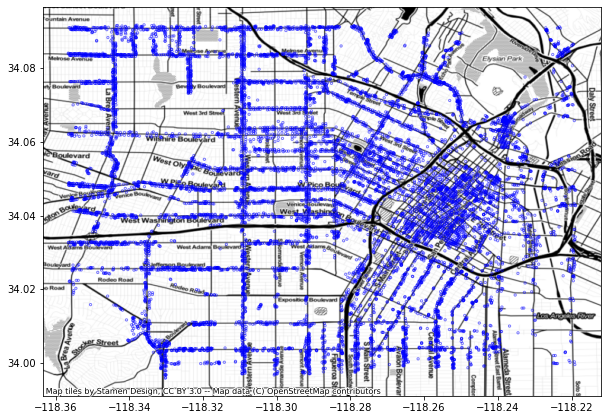

In [76]:
# get usage for university park neighborhood only
usage = elec_hoods_com[(elec_hoods_com['name'] == 'downtown') |
                      (elec_hoods_com['name'] == 'koreatown') |
                      (elec_hoods_com['name'] == 'westlake') |
                      (elec_hoods_com['name'] == 'pico-union') |
                      (elec_hoods_com['name'] == 'harvard heights')]

# spatial join LARIAC and parcels dataframe
parcels_com_df = parcels_df[parcels_df['UseType'] == 'Commercial'].copy() # filter for only commercial
parcels_com_df.drop_duplicates('geometry', inplace=True) # !!!REMOVE DUPLICATE PARCELS!!!
lariac_centroids_df = lariac_df.copy()
lariac_centroids_df['centroids'] = lariac_centroids_df.geometry.to_crs('epsg:3857').centroid
lariac_centroids_df.set_geometry('centroids', inplace=True)
lariac_centroids_df = lariac_centroids_df.to_crs('epsg:4326')
lariac_merged_inner = lariac_centroids_df.sjoin(parcels_com_df, how='inner', predicate = 'within')

# plot to visualize
ax = lariac_merged_inner.plot(figsize=(10,10), alpha=0.5, color='blue', facecolor='none', marker='o', markersize = 5)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_merged_inner.crs) # notice the crs must match between basemap and data
#ah_grid.plot(ax=ax, facecolor="none", edgecolor='gray')
#usage.plot(ax=ax, alpha=0.1, edgecolor='k')

In [77]:
lariac_merged_inner.set_geometry('geometry', inplace=True)

In [78]:
# spatial join the 2d grid and the neighborhood boundary
grid = ah_grid.overlay(usage, how='intersection')

In [79]:
# drop columns with 'index_*'
grid.drop(list(grid.filter(regex = 'index_')), axis=1, inplace=True)
lariac_merged_inner.drop(list(lariac_merged_inner.filter(regex = 'index_')), axis=1, inplace=True)

# add extra geometry column to save grid geometry for spatial joins
grid['grid_geometry'] = grid.geometry

# make the index a column
grid.reset_index(inplace=True)
# rename index to grid_cell_index
grid.rename(columns={'index':'grid_cell_index'}, inplace=True)

In [80]:
# overlay bulding footprints and grid
buildings_overlay_intersection = lariac_merged_inner.overlay(grid, how='intersection')


In [81]:
# calculate building volume and add as a new column (whole building, not segment of building)
buildings_overlay_intersection['VOLUME'] = buildings_overlay_intersection['AREA']*buildings_overlay_intersection['HEIGHT'] # units: cubic feet

# add column that describes the fraction of the whole building that segment represents
buildings_overlay_intersection['building_fraction'] = buildings_overlay_intersection.to_crs('epsg:3857').geometry.area/buildings_overlay_intersection['shape_area_whole']
buildings_overlay_intersection['VOLUME'] = buildings_overlay_intersection['building_fraction']*buildings_overlay_intersection['VOLUME']

# create column for total volume in that neighborhood
buildings_overlay_intersection['total_volume'] = buildings_overlay_intersection['VOLUME'].groupby(buildings_overlay_intersection['name']).transform('sum')


In [83]:
# df of total building volume in each grid cell
building_volume_df = buildings_overlay_intersection[['grid_cell_index', 'VOLUME']]
volume_by_cell = building_volume_df.groupby('grid_cell_index').sum()
# make the index a column
volume_by_cell.reset_index(inplace=True)

# add cells with no buildings 
volume_by_cell_all = volume_by_cell.merge(grid, how='outer') # outer join
volume_by_cell_all = volume_by_cell_all[['grid_cell_index','VOLUME', 'name',
                                         'usage','grid_geometry']] # only keep these columns
total_volumes = buildings_overlay_intersection[['name', 'total_volume']].copy()
total_volumes.drop_duplicates(inplace=True)
volume_by_cell_all = volume_by_cell_all.merge(total_volumes, how='outer')

In [89]:
# calculate volume-based weights and finally, the AHF
cell_area = stepsize**2 # area of single cell; stepsize is resolution in meters (defined above)
n_cells = len(grid) # number of total cells in neighborhood
seconds_in_year = 3.154e+7
ahf = gpd.GeoDataFrame(volume_by_cell_all, geometry='grid_geometry')
ahf['VOLUME'] = ahf['VOLUME'].fillna(0)
ahf['vol_frac'] = ahf['VOLUME']/ahf['total_volume']
ahf['electricity_use'] = ahf['usage']*ahf['vol_frac']*3.6*(10**6) # convert from kwh to joules
ahf['ahf'] = ahf['electricity_use']/cell_area/seconds_in_year
ahf.head()

,grid_cell_index,VOLUME,name,usage,grid_geometry,total_volume,vol_frac,electricity_use,ahf
0,0,40830.611325,koreatown,237015347.9,"POLYGON ((-118.32262 34.05512, -118.32262 34.0...",5.524537e+08,0.000074,6.306218e+10,0.199943
1,3,338744.924764,koreatown,237015347.9,"POLYGON ((-118.32262 34.05512, -118.32172 34.0...",5.524537e+08,0.000613,5.231857e+11,1.658801
2,4,222990.875094,koreatown,237015347.9,"POLYGON ((-118.32172 34.05586, -118.32172 34.0...",5.524537e+08,0.000404,3.444056e+11,1.091964
3,7,287158.321677,koreatown,237015347.9,"POLYGON ((-118.32172 34.05437, -118.32082 34.0...",5.524537e+08,0.000520,4.435111e+11,1.406186
4,8,25809.636900,koreatown,237015347.9,"POLYGON ((-118.32172 34.05437, -118.32172 34.0...",5.524537e+08,0.000047,3.986254e+10,0.126387


In [90]:
# convert values of zero to NA
ahf['ahf'].replace(0, np.nan, inplace=True)

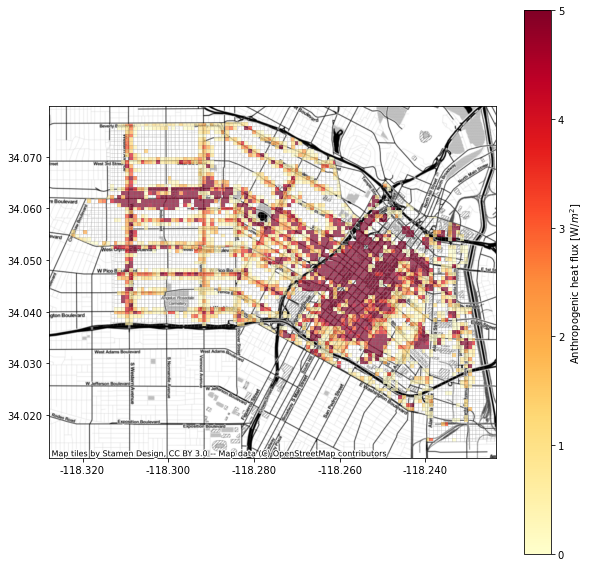

In [91]:
# plot to visualize
ax = ahf.plot(figsize=(10,10), column='ahf', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=5, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_merged_inner.crs) # notice the crs must match between basemap and data
grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [ ]:
# export ahf as shapefile
ahf.to_file('./data/output/ahf_central_la_com.shp')

In [ ]:
# histogram of ahf
ahf.hist(column='ahf', bins=30)

## Add time variability to Test Case 3: Central LA

### Create weights to represent time variability (i.e., seasonal, diurnal, weekday/weekend)

In [2]:
# import profiles from residential smart meter data
path = "./data/smart_meter"
all_files = glob.glob(os.path.join(path, "*.csv")) #make list of paths
load_profiles_dict = {}
for file in all_files:
    # Getting the file name without extension
    file_name = os.path.splitext(os.path.basename(file))[0]
    # Reading the file content to create a DataFrame
    df = pd.read_csv(file)
    # add to df_dict
    load_profiles_dict.update({file_name:df})

In [3]:
monthly_profile = load_profiles_dict['df_cz9_by_month']
seasonal_weights = monthly_profile['mean_norm']

In [4]:
summer_weekend_profile = load_profiles_dict['df_cz9_summer_weekend']['mean_norm']
summer_weekday_profile = load_profiles_dict['df_cz9_summer_weekday']['mean_norm']
winter_weekend_profile = load_profiles_dict['df_cz9_winter_weekend']['mean_norm']
winter_weekday_profile = load_profiles_dict['df_cz9_winter_weekday']['mean_norm']

In [5]:
summer_weekday_weekend_ratio = load_profiles_dict['df_cz9_summer_weekday']['mean'].sum()/load_profiles_dict['df_cz9_summer_weekend']['mean'].sum()
winter_weekday_weekend_ratio = load_profiles_dict['df_cz9_winter_weekday']['mean'].sum()/load_profiles_dict['df_cz9_winter_weekend']['mean'].sum()

<AxesSubplot:>

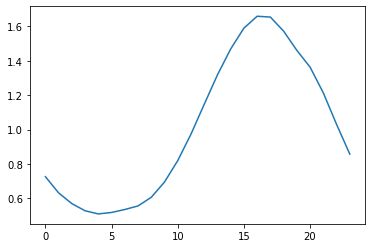

In [154]:
summer_weekday_profile.plot()

### Residential

In [6]:
# import ahf dataframe
ahf_res = gpd.read_file('./data/output/ahf_central_la_res.shp')

In [7]:
ahf_res.head()

,grid_cell_,VOLUME,name,pct_elec,usage_joul,total_volu,vol_frac,electricit,ahf,geometry
0,3,216805.342849,koreatown,0.391117,1.597187e+15,7.237845e+08,2.995440e-04,1.871211e+11,0.593282,"POLYGON ((-118.32262 34.05512, -118.32172 34.0..."
1,4,270122.094681,koreatown,0.391117,1.597187e+15,7.237845e+08,3.732079e-04,2.331380e+11,0.739182,"POLYGON ((-118.32172 34.05586, -118.32172 34.0..."
2,5,371712.948593,koreatown,0.391117,1.597187e+15,7.237845e+08,5.135685e-04,3.208194e+11,1.017182,"POLYGON ((-118.32172 34.05661, -118.32172 34.0..."
3,6,353.352543,koreatown,0.391117,1.597187e+15,7.237845e+08,4.882013e-07,3.049728e+08,0.000967,"POLYGON ((-118.32172 34.05661, -118.32207 34.0..."
4,8,406436.340734,koreatown,0.391117,1.597187e+15,7.237845e+08,5.615433e-04,3.507885e+11,1.112202,"POLYGON ((-118.32172 34.05437, -118.32172 34.0..."


In [139]:
# create diurnal animation for summer weekend
ahf_res_summer_weekend = ahf_res.copy()
for i in range(len(summer_weekend_profile)):
    column_name = 'hr_' + str(i)
    ahf_res_summer_weekend[column_name] = seasonal_weights[7]*ahf_res_summer_weekend['ahf']*summer_weekend_profile[i]*(1/summer_weekday_weekend_ratio)

In [140]:
# loop through each hour and save plot
for i in range(24):
    # set column
    column_name = "hr_" + str(i)
    
    # plot to visualize
    ax = ahf_res_summer_weekend.plot(figsize=(12,8), column=column_name, alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=5, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326') # notice the crs must match between basemap and data
    grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # add a title
    ax.set_title('Residential AHF: summer weekend', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # position the annotation to the bottom left
    ax.annotate('Hour ' + str(i),
            xy=(0.4, .13), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=30)
    
    # save file
    path = Path('summer_weekend')
    filename = 'hour_' + str(i) + '.png'
    filepath = path / filename
    ax.figure.savefig(filepath, facecolor='white',dpi=300)
    plt.cla()
    plt.clf()
    plt.close()

In [141]:
# create diurnal animation for summer weekday
ahf_res_summer_weekday = ahf_res.copy()
for i in range(len(summer_weekday_profile)):
    column_name = 'hr_' + str(i)
    ahf_res_summer_weekday[column_name] = seasonal_weights[7]*ahf_res_summer_weekday['ahf']*summer_weekday_profile[i]*(summer_weekday_weekend_ratio)

In [142]:
# loop through each hour and save plot
for i in range(24):
    # set column
    column_name = "hr_" + str(i)
    
    # plot to visualize
    ax = ahf_res_summer_weekday.plot(figsize=(12,8), column=column_name, alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=5, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326') # notice the crs must match between basemap and data
    grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # add a title
    ax.set_title('Residential AHF: summer weekday', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # position the annotation to the bottom left
    ax.annotate('Hour ' + str(i),
            xy=(0.4, .13), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=30)
    
    # save file
    path = Path('summer_weekday')
    filename = 'test_' + str(i) + '.png'
    filepath = path / filename
    ax.figure.savefig(filepath, facecolor='white',dpi=300)
    plt.cla()
    plt.clf()
    plt.close()

In [143]:
# create diurnal animation for winter weekend
ahf_res_winter_weekend = ahf_res.copy()
for i in range(len(winter_weekend_profile)):
    column_name = 'hr_' + str(i)
    ahf_res_winter_weekend[column_name] = seasonal_weights[11]*ahf_res_winter_weekend['ahf']*winter_weekend_profile[i]*(1/winter_weekday_weekend_ratio)

In [144]:
# loop through each hour and save plot
for i in range(24):
    # set column
    column_name = "hr_" + str(i)
    
    # plot to visualize
    ax = ahf_res_winter_weekend.plot(figsize=(12,8), column=column_name, alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=5, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326') # notice the crs must match between basemap and data
    grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # add a title
    ax.set_title('Residential AHF: winter weekend', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # position the annotation to the bottom left
    ax.annotate('Hour ' + str(i),
            xy=(0.4, .13), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=30)
    
    # save file
    path = Path('winter_weekend')
    filename = 'hour_' + str(i) + '.png'
    filepath = path / filename
    ax.figure.savefig(filepath, facecolor='white',dpi=300)
    plt.cla()
    plt.clf()
    plt.close()

In [145]:
# create diurnal animation for winter weekday
ahf_res_winter_weekday = ahf_res.copy()
for i in range(len(winter_weekday_profile)):
    column_name = 'hr_' + str(i)
    ahf_res_winter_weekday[column_name] = seasonal_weights[11]*ahf_res_winter_weekday['ahf']*winter_weekday_profile[i]*(winter_weekday_weekend_ratio)

In [146]:
# loop through each hour and save plot
for i in range(24):
    # set column
    column_name = "hr_" + str(i)
    
    # plot to visualize
    ax = ahf_res_winter_weekday.plot(figsize=(12,8), column=column_name, alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=5, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326') # notice the crs must match between basemap and data
    grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # add a title
    ax.set_title('Residential AHF: winter weekday', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # position the annotation to the bottom left
    ax.annotate('Hour ' + str(i),
            xy=(0.4, .13), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=30)
    
    # save file
    path = Path('winter_weekday')
    filename = 'test_' + str(i) + '.png'
    filepath = path / filename
    ax.figure.savefig(filepath, facecolor='white',dpi=300)
    plt.cla()
    plt.clf()
    plt.close()

In [ ]:
"""
Issues using funcanimation with geopandas.
"""
# # try using funcanimation 
# fig, ax = plt.subplots()
# ims = []
# def update_fig(hour):
#     geos = ahf_res_summer_weekend['geometry'].values
#     col = 'hr_' + str(hour)
#     artist = ahf_res_summer_weekend.plot(ax=ax, column=col, alpha=0.7, cmap='YlOrRd', vmin=0, vmax=5, legend=True)
#     ims.append(artist)
#     ax.set_title('Hour ' + str(hour))
#     return ims
# anim = FuncAnimation(fig, update_fig, interval=500, repeat=True, frames=range(24))
# plt

In [ ]:
ahf_res_summer_weekend.head()

### Commercial

In [149]:
# import ahf dataframe
ahf_com = gpd.read_file('./data/output/ahf_central_la_com.shp')

In [148]:
com_profile_path = '/Users/josephko/USC/Research/Anthropogenic Heat/nrel/comstock/avg_electricity_consumption_annual.csv'
com_profile_annual = pd.read_csv(com_profile_path)
com_profile_annual = com_profile_annual['hourly_avg_norm'].copy()

<AxesSubplot:>

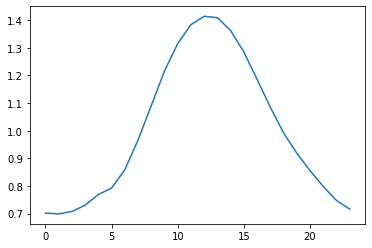

In [153]:
com_profile_annual.plot()

In [150]:
# create diurnal animation, annual average
ahf_com_annual = ahf_com.copy()
for i in range(len(com_profile_annual)):
    column_name = 'hr_' + str(i)
    ahf_com_annual[column_name] = ahf_com_annual['ahf']*com_profile_annual[i]

In [152]:
# loop through each hour and save plot
for i in range(24):
    # set column
    column_name = "hr_" + str(i)
    
    # plot to visualize
    ax = ahf_com_annual.plot(figsize=(12,8), column=column_name, alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=5, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326') # notice the crs must match between basemap and data
    grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # add a title
    ax.set_title('Commercial AHF: average day in year', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # position the annotation to the bottom left
    ax.annotate('Hour ' + str(i),
            xy=(0.4, .1), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=30)
    
    # save file
    path = Path('com_avg')
    filename = 'test_' + str(i) + '.png'
    filepath = path / filename
    ax.figure.savefig(filepath, facecolor='white',dpi=300)
    plt.cla()
    plt.clf()
    plt.close()

## Commercial + Residential Combined

### Proof of concept: University Park neighborhood

In [ ]:
ahf_combined = ahf.copy()
ahf_combined['ahf'] = ahf['ahf'] + ahf_com['ahf_area_weighted']
ahf_combined['ahf_naive'] = ahf['ahf_naive'] + ahf_com['ahf_naive']

In [ ]:
# plot with building weighting applied
ax = ahf_combined.plot(figsize=(10,10), column='ahf', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_overlay_intersection.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
buildings_usc_overlay_intersection_com.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [ ]:
# plot without building weighting (i.e., naive)
ax = ahf_com.plot(figsize=(10,10), column='ahf_naive', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_overlay_intersection.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
buildings_usc_overlay_intersection_com.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))